# LLMs for Fuzzy Matching Transaction Descriptors to Merchants

Submitted by: Rishabh Kaushick <br>
Program: Master of Science in Information Systems <br>
Course: CSYE 7230 - Software Engineering & Generative Artificial Intelligence <br>
Term: Spring 2025 <br>
Supervised by: Prof. Junwei Huang

# 1. Environment Setup

In [1]:
# downloading libraries
%pip install --quiet openai
%pip install --quiet google-generativeai

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [72]:
%pip install --quiet scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [133]:
%pip install --quiet xgboost

Note: you may need to restart the kernel to use updated packages.


In [182]:
%pip install --quiet ollama

Note: you may need to restart the kernel to use updated packages.


In [4]:
# tf-keras is required for sentence-transformers
%pip install --quiet tf-keras
%pip install --quiet sentence-transformers faiss-cpu

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install --quiet langchain
%pip install --quiet -U langchain-community

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [6]:
%reset

## Importing Libraries

In [9]:
import os

In [10]:
os.environ["HF_HUB_DOWNLOAD_TIMEOUT"] = "120"  # Set timeout to 120 seconds

In [11]:
# importing required libraries

import os
import random
import time
from typing import List

# data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack

# llm apis
from openai import OpenAI
import google.generativeai as genai

# deep learning/ ml libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import ollama
import joblib
from sentence_transformers import SentenceTransformer
import faiss
from langchain.utilities import SearxSearchWrapper

## Setting up GPU

In [12]:
print(f"PyTorch version: {torch.__version__}")
print(f"Is CUDA available: {torch.cuda.is_available()}")
 
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"cuDNN version: {torch.backends.cudnn.version()}")
    print(f"cuDNN enabled: {torch.backends.cudnn.enabled}")
    print(f"GPU Count: {torch.cuda.device_count()}")
    
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"Memory Allocated: {torch.cuda.memory_allocated(i) / 1024**2:.2f} MB")
        print(f"Memory Reserved: {torch.cuda.memory_reserved(i) / 1024**2:.2f} MB")
 
else:
    print("CUDA is not available. Running on CPU.")

PyTorch version: 2.6.0
Is CUDA available: False
CUDA is not available. Running on CPU.


# 2. Dataset Preparation and Exploration

In [13]:
NUM_MATCH = 2500
NUM_MISMATCH = 2500

MERCHANT_EXAMPLES = [
    "Walmart Ottawa Store 001",
    "McDonald's Vancouver Store 234",
    "Amazon Canada Marketplace",
    "Uber Ride Los Angeles",
    "Tim Hortons Toronto Store 450"
]

## LLMs to Generate Synthetic Data

In [14]:
LLMS = ["ChatGPT-4o", "Gemini 1.5 Pro", "Gemini 2.0-Flash-Lite"]

### Generating Merchant Names

### OpenAI ChatGPT-4o Generated Data

In [15]:
openai_client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

In [13]:
def generate_merchant_names_openai(num_merchants: int = 500) -> List[str]:
    prompt = f"""
                Generate {num_merchants} realistic merchant or store names that could appear in financial transaction records.
                Include a mix of:
                - Retail stores
                - Grocery stores
                - Fast food chains
                - Gas stations
                - Online marketplaces
                - Ride-sharing companies
                - Entertainment venues
                - Restaurants and cafes
                - Banks and financial institutions

                The names should sound real and diverse, and primarily based in North America. Output one name per line without numbering or bullets.
                Here are some examples of the merchants: 
                {MERCHANT_EXAMPLES}
                """
    response = openai_client.responses.create(
        model="gpt-4o",
        input=[{"role": "user", "content": prompt}],
        temperature=0.85,
        max_output_tokens=2000
    )
    merchant_text = response.output_text
    merchant_list = merchant_text.strip().split('\n')
    merchant_list = [m.strip() for m in merchant_list if m.strip()]
    return merchant_list[:num_merchants]


In [ ]:
print("Generating merchant names...")
LLM_MERCHANTS = generate_merchant_names_openai(num_merchants=500)
print(f"Generated {len(LLM_MERCHANTS)} merchant names.")

# save the LLM generated merchants in Pandas & CSV:
merchant_df = pd.DataFrame(LLM_MERCHANTS, columns=["LLM Generated Merchant"])
merchant_df.to_csv("./data/llm_generated_merchants.csv", index=False)
print("LLM generated merchants saved to CSV.")

Generating merchant names...
Generated 311 merchant names.
LLM generated merchants saved to CSV.


In [16]:
# let's review the merchants that ChatGPT generated
print("Sample of LLM generated merchants:")
print(merchant_df.sample(10, random_state=42))

Sample of LLM generated merchants:
             LLM Generated Merchant
290          IHOP Canada Restaurant
9          Netflix Subscription USA
57           PayPal Online Services
60   Chipotle Mexican Grill Toronto
25         AMC Theatres Los Angeles
63      ExxonMobil Station New York
92    Papa John's Chicago Store 678
184          Etsy Craft Marketplace
244          Amazon Canada Services
46     Pizza Hut New York Store 789


These look like good messy merchant descriptors. Thanks ChatGPT!

Let us add an extra column which has details of the model which generated the data. In case we want to use other LLMs to generate this data in the future, this information will be useful to know.

In [18]:
# adding another column called "LLM" which holds the value 'ChatGPT-4o'
merchant_df["LLM"] = "ChatGPT-4o"

In [20]:
merchant_df.head()

,LLM Generated Merchant,LLM
0,Walmart Chicago Store 102,ChatGPT-4o
1,Target Atlanta Supercenter,ChatGPT-4o
2,Starbucks New York Store 678,ChatGPT-4o
3,Costco Wholesale Seattle,ChatGPT-4o
4,Shell Gas Station Houston,ChatGPT-4o


In [21]:
# Looks good. Let's save it again
merchant_df.to_csv("./data/llm_generated_merchants.csv", index=False)

##### Loading The Pre-Generated Merchant Names

In [16]:
# load the merchants from CSV
merchant_df = pd.read_csv("./data/llm_generated_merchants.csv")
print(f"Loaded {len(merchant_df)} merchants from CSV.")

Loaded 311 merchants from CSV.


### Method to Generate Merchant Messy Descriptors (Match)

Next, we must let's use the messy merchants again through LLMs to ask them to create 5 messy descriptors for each merchant.

In [51]:
def generate_messy_descriptors_openai(merchant_names: List[str]) -> str:
    prompt = f"""You are helping generate synthetic messy merchant descriptors for training a machine learning model.
                For each merchant name below, generate 5 messy descriptors that could realistically appear in transaction data.

                The messy descriptors should:
                - Use abbreviations, typos, and truncations.
                - Randomly include store numbers, city names, or country codes.
                - Add random symbols like *, -, #, etc.
                - Vary the word order sometimes.
                - Maintain overall meaning.

                Output format:
                - Start each merchant block with 'Merchant: <Merchant Name>'
                - List 5 messy descriptors (one per line, no bullets)

                Merchants:
                {chr(10).join(merchant_names)}
                """
    response = openai_client.responses.create(
        model="gpt-4.1",
        input=[{"role": "user", "content": prompt}],
        temperature=0.85,
        max_output_tokens=4000,
    )
    messy_text = response.output_text
    return messy_text

Let's test the above method to see how ChatGPT generates the data.

In [29]:
chatgpt_messy_descriptors_starbucks = generate_messy_descriptors_openai(merchant_names=['Starbucks New York Store 678'])

In [30]:
chatgpt_messy_descriptors_starbucks

'Merchant: Starbucks New York Store 678  \nStrbcks NY 678#  \nSbucks Store 678* NY  \nStarbux NewYrk 678#  \nStarbucks678 NY  \nSt*rBk NY678 Store  \n\n'

Let's write another method to parse the ChatGPT generated data.

In [31]:
# Parses the batched output from OpenAI or Gemini.
def parse_batch_output(text: str) -> dict:
    # Returns a dictionary: {merchant_name: [list of messy descriptors]}
    results = {}
    current_merchant = None
    lines = text.splitlines()

    for line in lines:
        line = line.strip()
        if not line:
            continue
        if line.startswith("Merchant:"):
            current_merchant = line.replace("Merchant:", "").strip()
            results[current_merchant] = []
        elif current_merchant:
            results[current_merchant].append(line)

    # Optional: Keep only 5 descriptors per merchant
    # for merchant in results:
    #     results[merchant] = results[merchant][:5]
    return results

In [32]:
starbucks_messy_descriptors = parse_batch_output(chatgpt_messy_descriptors_starbucks)
print("Parsed messy descriptors for Starbucks:")
print(starbucks_messy_descriptors)

Parsed messy descriptors for Starbucks:
{'Starbucks New York Store 678': ['Strbcks NY 678#', 'Sbucks Store 678* NY', 'Starbux NewYrk 678#', 'Starbucks678 NY', 'St*rBk NY678 Store']}


This looks great. Let's do the same with Gemini.

### Google Gemini Generated Data

In [17]:
genai.configure(api_key=os.getenv("GEMINI_API_KEY"))
# gemini_model = genai.GenerativeModel("gemini-1.5-pro")
# initially I used gemini-1.5-pro
# now I will use gemini-2.0-flash-lite
gemini_model = genai.GenerativeModel("gemini-2.0-flash-lite")

In [34]:
def generate_messy_descriptors_gemini(merchant_names: List[str]) -> str:
    prompt = f"""
                You are helping generate synthetic messy merchant descriptors for training a machine learning model.

                For each merchant name below, generate 5 messy descriptors that could realistically appear in transaction data. 

                The messy descriptors should:
                - Use abbreviations, typos, and truncations.
                - Randomly include store numbers, city names, or country codes.
                - Add random symbols like *, -, #, etc.
                - Vary the word order sometimes.
                - Maintain overall meaning.

                Output format:
                - Start each merchant block with 'Merchant: <Merchant Name>'
                - List 5 messy descriptors (one per line, no bullets)

                Merchants:
                {chr(10).join(merchant_names)}
                """
    response = gemini_model.generate_content(
        prompt,
        generation_config={
            "temperature": 0.85,
            "top_p": 1.0,
            "max_output_tokens": 4000,
        },
    )
    messy_text = response.text
    return messy_text

In [ ]:
# def generate_messy_descriptors_batch_gemini(merchant_names: List[str]) -> dict:
#     prompt = f"""
# You are helping generate synthetic messy merchant descriptors for training a machine learning model.

# For each merchant name below, generate 5 messy descriptors that could realistically appear in transaction data.

# The messy descriptors should:
# - Use abbreviations, typos, and truncations
# - Randomly include store numbers, city names, or country codes
# - Add random symbols like *, -, #, etc.
# - Vary word order sometimes
# - Maintain overall meaning

# Output format:
# - Start each merchant block with 'Merchant: <Merchant Name>'
# - List 5 messy descriptors (one per line, no bullets)

# Merchants:
# {chr(10).join(merchant_names)}
# """
#     response = gemini_model.generate_content(
#         prompt,
#         generation_config={
#             "temperature": 0.85,
#             "top_p": 1.0,
#             "max_output_tokens": 4000,
#         },
#     )
#     messy_text = response.text
#     return parse_batch_output(messy_text)


Again testing it before running it on 2500 rows of data.

In [35]:
gemini_messy_descriptors_starbucks = generate_messy_descriptors_openai(merchant_names=['Starbucks New York Store 678'])

In [36]:
gemini_messy_descriptors_starbucks

'Merchant: Starbucks New York Store 678  \nStarbcks NY #678  \nStor 678*Starbucks-NY  \nStarbux N.Y. 678  \nNY678*Starbucks  \nStore 678 New York Starbcks  '

In [37]:
gemini_messy_descriptors_starbucks = parse_batch_output(gemini_messy_descriptors_starbucks)
print("Parsed messy descriptors for Starbucks (Gemini):")
print(gemini_messy_descriptors_starbucks)

Parsed messy descriptors for Starbucks (Gemini):
{'Starbucks New York Store 678': ['Starbcks NY #678', 'Stor 678*Starbucks-NY', 'Starbux N.Y. 678', 'NY678*Starbucks', 'Store 678 New York Starbcks']}


The helper method looks good. We also successfully tested both the ChatGPT API & Gemini API. Now we can generate around 2,500 rows of data each from ChatGPT & Gemini.

### Method to Generate Merchant Messy Descriptors (Mismatch)
Apart from the 'Match', we also need to write some logic for the 'Mismatch'. Here, we can randomly take the merchant list and 

In [49]:
def random_mismatch_merchant(exclude: str, merchant_list: List[str]) -> str:
    other_merchants = [m for m in merchant_list if m != exclude]
    return random.choice(other_merchants)

The above code will randomly pick another merchant. This is good to begin with but we can try to get better mismatches. Let's try to do this using LLMs.

In [ ]:
# using the latest chatgpt-4.1 model
LLMS = ["ChatGPT-4.1", "Gemini 1.5 Pro"]

def generate_hard_mismatches_openai(merchant_names: List[str]) -> str:
    prompt = f"""
You are helping generate synthetic confusing merchant descriptors for training a machine learning model.

Given a list of real merchant names, generate 5 messy descriptors for each merchant that look very similar but actually belong to a different merchant entity.

Rules:
- Descriptors should be close in text to the original merchant.
- But they should represent a different merchant (e.g., competing brand, different branch, slightly wrong store number, different location).
- Introduce small changes like brand tweaks, number changes, or different location names.

Example: 
'AMZNMKTP#123-CAN' does not belong to 'Amazing Mart Canada'
'STRBCKS#001-TOR' does not belong to 'Star Books Toronto'

Output format:
- Output one block per merchant starting with 'Merchant: <Merchant Name>'
- Then list 5 messy descriptors (one per line, no numbering, no bullets).

Merchants:
{chr(10).join(merchant_names)}
"""
    response = openai_client.responses.create(
        model="gpt-4.1",
        input=[{"role": "user", "content": prompt}],
        temperature=0.85,
        max_output_tokens=4000,
    )
    messy_text = response.output_text
    return messy_text


Testing that this works with two different merchants

In [42]:
test_mismatch_descriptors_chatgpt = generate_hard_mismatches_openai(merchant_names=['Starbucks New York Store 678', 'PayPal Transfer'])

In [43]:
test_mismatch_descriptors_chatgpt

'Merchant: Starbucks New York Store 678  \nStarbuckz New York Store 687  \nStarbucks NYC Store 678  \nStarbucks New York Store 768  \nStarbucks Brooklyn Store 678  \nStarbucks New York Store 679  \n\nMerchant: PayPal Transfer  \nPayPol Transfer  \nPayPal Transfers  \nPayPal Tranfer  \nPayPal TXFR  \nPayPal Xfer'

In [44]:
test_mismatch_descriptors_chatgpt_dict = parse_batch_output(test_mismatch_descriptors_chatgpt)
test_mismatch_descriptors_chatgpt_dict

{'Starbucks New York Store 678': ['Starbuckz New York Store 687',
  'Starbucks NYC Store 678',
  'Starbucks New York Store 768',
  'Starbucks Brooklyn Store 678',
  'Starbucks New York Store 679'],
 'PayPal Transfer': ['PayPol Transfer',
  'PayPal Transfers',
  'PayPal Tranfer',
  'PayPal TXFR',
  'PayPal Xfer']}

The above has created mismatched messy discriptors, but it isn't looking like real-world transactions. Therefore, I have decided to not use LLMs for mismatched transactions. Rather I will use the already generated transactions and induce some issues in them.

In [46]:
def introduce_typo(word):
    """Introduce a random character replacement typo in a word."""
    if len(word) < 3:
        return word
    idx = random.randint(1, len(word) - 2)
    typo_char = random.choice('abcdefghijklmnopqrstuvwxyz')
    return word[:idx] + typo_char + word[idx+1:]

def randomly_drop_letter(word):
    """Randomly drop one letter from the word."""
    if len(word) <= 3:
        return word
    idx = random.randint(0, len(word) - 1)
    return word[:idx] + word[idx+1:]

def truncate_word(word):
    """Truncate the word randomly."""
    if len(word) < 4:
        return word
    return word[:random.randint(2, len(word)-1)]

def shuffle_words(words):
    """Shuffle word order slightly."""
    random.shuffle(words)
    return words

def add_random_symbol(word):
    """Add random symbols like #, *, - into the word."""
    symbols = ['#', '*', '-', '.']
    idx = random.randint(0, len(word))
    symbol = random.choice(symbols)
    return word[:idx] + symbol + word[idx:]

def create_hard_mismatch_with_typos(merchant_name: str) -> str:
    """Create a hard mismatch messy descriptor from a merchant name."""
    words = merchant_name.split()

    transformation = random.choice(['typo', 'drop', 'truncate', 'shuffle', 'symbol'])

    if transformation == 'typo':
        idx = random.randint(0, len(words)-1)
        words[idx] = introduce_typo(words[idx])

    elif transformation == 'drop':
        idx = random.randint(0, len(words)-1)
        words[idx] = randomly_drop_letter(words[idx])

    elif transformation == 'truncate':
        idx = random.randint(0, len(words)-1)
        words[idx] = truncate_word(words[idx])

    elif transformation == 'shuffle':
        words = shuffle_words(words)

    elif transformation == 'symbol':
        idx = random.randint(0, len(words)-1)
        words[idx] = add_random_symbol(words[idx])

    # Sometimes apply two transformations randomly
    if random.random() < 0.3:
        return create_hard_mismatch_with_typos(' '.join(words))

    return ' '.join(words)


Let's test the above method for mismatched merchant descriptors:

In [53]:
messy_descriptor_match = "AMZN MKTP*CAN123"
for _ in range(5):
    print(create_hard_mismatch_with_typos(messy_descriptor_match))

AMZN MKTP*CAN23
AM*ZN MKTP*CAN123
MKTP*CAN123 AMZN
-AM MzTP*CAN123
AMZN KTP*CAN123


The hard-mismatches along with the easy mismatches (random_mismatch_merchant method) should be good enough for now to generate the mismatch data. 

### Generating Match & Mismatch Data

In [ ]:
# all_data = []

# for llm in LLMS:
#     print(f"Generating data for {llm}...")

#     # reset matches_created for each llm
#     matches_created = 0
#     while matches_created < NUM_MATCH:
#         # Randomly select a merchant from the list and generate messy descriptors for it
#         merchant = random.choice(LLM_MERCHANTS)
#         try:
#             if llm == "ChatGPT":
#                 messy_list = generate_messy_descriptors_openai(merchant)
#             elif llm == "Gemini":
#                 messy_list = generate_messy_descriptors_gemini(merchant)
#             else:
#                 raise ValueError("Unknown LLM")

#             for messy in messy_list:
#                 all_data.append({
#                     "Messy Descriptor": messy,
#                     "Merchant Name": merchant,
#                     "Label": "MATCH",
#                     "Generated By": llm
#                 })
#                 matches_created += 1
#                 if matches_created >= NUM_MATCH:
#                     break

#         except Exception as e:
#             print(f"Error during MATCH generation: {e}")
#             time.sleep(2)

#     # MISMATCH examples
#     mismatches_created = 0
#     while mismatches_created < NUM_MISMATCH:
#         merchant = random.choice(LLM_MERCHANTS)
#         mismatch_merchant = random_mismatch_merchant(merchant, LLM_MERCHANTS)

#         try:
#             if llm == "ChatGPT":
#                 messy_list = generate_messy_descriptors_openai(mismatch_merchant)
#             elif llm == "Gemini":
#                 messy_list = generate_messy_descriptors_gemini(mismatch_merchant)
#             else:
#                 raise ValueError("Unknown LLM")

#             for messy in messy_list:
#                 all_data.append({
#                     "Messy Descriptor": messy,
#                     "Merchant Name": merchant,  # Important: NOT matching
#                     "Label": "MISMATCH",
#                     "Generated By": llm
#                 })
#                 mismatches_created += 1
#                 if mismatches_created >= NUM_MISMATCH:
#                     break

#         except Exception as e:
#             print(f"Error during MISMATCH generation: {e}")
#             time.sleep(2)

In [9]:
LLMS

['ChatGPT-4o', 'Gemini 1.5 Pro', 'Gemini 2.0-Flash-Lite']

In [ ]:
# all_data = []
# batch_size = 10
# NUM_MATCH = 2500
# NUM_MISMATCH = 2500
# HARD_MISMATCH_PROBABILITY = 0.5  # 50% chance to use hard mismatch


# # Main Loop for MISMATCH Generation

# for llm in LLMS:
#     print(f"Generating data for {llm}...")
#     matches_created = 0
#     # MATCH examples
#     while matches_created < NUM_MATCH:
#         # merchant = random.choice(LLM_MERCHANTS)
#         messy_batch = random.
#         try:
#             if llm == "ChatGPT-4.1":
#                 messy_list = generate_messy_descriptors_openai([merchant])
#             elif llm == "Gemini 1.5 Pro":
#                 messy_list = generate_messy_descriptors_gemini([merchant])
#             else:
#                 raise ValueError("Unknown LLM")

#             for messy in messy_list.get(merchant, []):
#                 all_data.append({
#                     "Messy Descriptor": messy,
#                     "Merchant Name": merchant,
#                     "Label": "MATCH",
#                     "Generated By": llm
#                 })
#                 matches_created += 1
#                 if matches_created >= NUM_MATCH:
#                     break

#         except Exception as e:
#             print(f"Error during MATCH generation: {e}")
#             time.sleep(2)

#     # MISMATCH examples
#     mismatches_created = 0
#     while mismatches_created < NUM_MISMATCH:
#         merchant = random.choice(LLM_MERCHANTS)

#         try:
#             if random.random() < HARD_MISMATCH_PROBABILITY:
#                 # Generate HARD mismatch using typo, shuffle, etc.
#                 messy_descriptor = create_hard_mismatch_with_typos(merchant)
#             else:
#                 # Easy mismatch: pick a random messy descriptor from another merchant
#                 mismatch_merchant = random_mismatch_merchant(merchant, LLM_MERCHANTS)

#                 if llm == "ChatGPT":
#                     messy_list = generate_messy_descriptors_openai([mismatch_merchant])
#                 elif llm == "Gemini":
#                     messy_list = generate_messy_descriptors_gemini([mismatch_merchant])
#                 else:
#                     raise ValueError("Unknown LLM")

#                 # Randomly pick one messy descriptor from list
#                 messy_descriptor = random.choice(messy_list.get(mismatch_merchant, ["UNKNOWN"]))

#             all_data.append({
#                 "Messy Descriptor": messy_descriptor,
#                 "Merchant Name": merchant,
#                 "Label": "MISMATCH",
#                 "Generated By": llm
#             })
#             mismatches_created += 1

#         except Exception as e:
#             print(f"Error during MISMATCH generation: {e}")
#             time.sleep(2)


In [68]:
all_data = []
batch_size = 10
NUM_MATCH = 2500
NUM_MISMATCH = 2500
HARD_MISMATCH_PROBABILITY = 0.5  # 50% chance to use hard mismatch

for llm in LLMS:
    print(f"Generating data for {llm}...")

    # MATCH examples
    matches_created = 0
    while matches_created < NUM_MATCH:
        # randomly sending a batch of merchants to the LLM
        batch_llm_merchants = random.sample(LLM_MERCHANTS, batch_size)
        try:
            if llm == "ChatGPT-4.1":
                messy_batch = generate_messy_descriptors_openai(batch_llm_merchants)
            elif llm == "Gemini 1.5 Pro":
                messy_batch = generate_messy_descriptors_gemini(batch_llm_merchants)
            else:
                raise ValueError("Unknown LLM")
            
            # updating the messy_batch to be a dictionary
            messy_batch = parse_batch_output(messy_batch)

            for merchant in batch_llm_merchants:
                descriptors = messy_batch.get(merchant, [])
                for messy in descriptors:
                    all_data.append({
                        "Messy Descriptor": messy,
                        "Merchant Name": merchant,
                        "Label": "MATCH",
                        "Generated By": llm
                    })
                    matches_created += 1
                    if matches_created >= NUM_MATCH:
                        break
                if matches_created >= NUM_MATCH:
                    break

        except Exception as e:
            print(f"Error during MATCH generation: {e}")
            time.sleep(2)
    
    print(f"Generated {matches_created} MATCH examples for {llm}...")

    # MISMATCH examples
    mismatches_created = 0
    while mismatches_created < NUM_MISMATCH:
        merchant = random.choice(LLM_MERCHANTS)
        # Get a random messy descriptor for the same merchant with the label 'MATCH'
        match_descriptors = [entry["Messy Descriptor"] for entry in all_data if entry["Merchant Name"] == merchant and entry["Label"] == "MATCH"]
        if match_descriptors:
            random_match_descriptor = random.choice(match_descriptors)
        else:
            random_index = random.randint(0, len(all_data) - 1)
            random_match_descriptor = all_data[random_index]["Messy Descriptor"]
        
        try:
            if random.random() < HARD_MISMATCH_PROBABILITY:
                messy_descriptor = create_hard_mismatch_with_typos(random_match_descriptor)
                all_data.append({
                                    "Messy Descriptor": messy_descriptor,
                                    "Merchant Name": merchant,
                                    "Label": "MISMATCH",
                                    "Generated By": "hard_mismatch_logic"
                                })
            else:
                mismatch_merchant = random_mismatch_merchant(merchant, LLM_MERCHANTS)
                all_data.append({
                                    "Messy Descriptor": random_match_descriptor,
                                    "Merchant Name": mismatch_merchant,
                                    "Label": "MISMATCH",
                                    "Generated By": "random_mismatch_logic"
                                })
                # if llm == "ChatGPT":
                #     messy_batch = generate_messy_descriptors_openai([mismatch_merchant])
                # elif llm == "Gemini":
                #     messy_batch = generate_messy_descriptors_gemini([mismatch_merchant])
                # else:
                #     raise ValueError("Unknown LLM")

                # messy_descriptor = random.choice(messy_batch.get(mismatch_merchant, ["UNKNOWN"]))

            
            mismatches_created += 1

        except Exception as e:
            print(f"Error during MISMATCH generation: {e}")
            time.sleep(2)
    
    print(f"Generated {mismatches_created} MISMATCH examples for {llm}...")

Generating data for ChatGPT-4.1...
Generated 2500 MATCH examples for ChatGPT-4.1...
Generated 2500 MISMATCH examples for ChatGPT-4.1...
Generating data for Gemini 1.5 Pro...
Error during MATCH generation: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 55
}
]
Error during MATCH generation: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 53
}
]
Error during MATCH generation: 429 You exceeded your current quo

KeyboardInterrupt: 

The above code was able to generate synthetic data from ChatGPT API, but it was unable to do this from Gemini.

Based on the above error, I could see that the Gemini API free-tier has the following rate limiting:

| Model 	               | Requests Per Minute | Tokens Per Minute | Requests Per Day |
|--------------------------|---------------------|-------------------|------------------|
| Gemini 1.5 Pro 	       | 2 	                 | 32,000	         | 50               |
| Gemini 1.5 Flash 	       | 15	                 | 1,000,000 	     | 1,500            |
| Gemini 2.0 Flash-Lite    | 30	                 | 1,000,000 	     | 1,500            |
| Gemini 2.0 Flash 	       | 15	                 | 1,000,000 	     | 1,500            |


The Gemini 1.5 Pro model that I was using was allowed to run only 2 requests per minute & 50 per day, with very low tokens per minute. Therefore, considering time and accuracy, I have decided to use a better model like Gemini 2.0-Flash-Lite, and have updated the code so that it can space out the API requests.


In [69]:
len(all_data)

5350

In [70]:
all_data[0:5]

[{'Messy Descriptor': 'EBAY*ELEC #1023 USA',
  'Merchant Name': 'eBay Electronics USA',
  'Label': 'MATCH',
  'Generated By': 'ChatGPT-4.1'},
 {'Messy Descriptor': 'USA EBAY ELEC SVC-882',
  'Merchant Name': 'eBay Electronics USA',
  'Label': 'MATCH',
  'Generated By': 'ChatGPT-4.1'},
 {'Messy Descriptor': 'EbayElectronicsUS*CA',
  'Merchant Name': 'eBay Electronics USA',
  'Label': 'MATCH',
  'Generated By': 'ChatGPT-4.1'},
 {'Messy Descriptor': 'EBAY ELEC-TRNC USA 5548',
  'Merchant Name': 'eBay Electronics USA',
  'Label': 'MATCH',
  'Generated By': 'ChatGPT-4.1'},
 {'Messy Descriptor': 'EBY ELCTRNX USA*',
  'Merchant Name': 'eBay Electronics USA',
  'Label': 'MATCH',
  'Generated By': 'ChatGPT-4.1'}]

In [71]:
# Saving the data to CSV

messy_descriptor_df = pd.DataFrame(all_data)
messy_descriptor_df.to_csv("./data/synthetic_merchant_data.csv", index=False)

print("Data generation complete! Saved to './data/synthetic_merchant_data.csv'.")

Data generation complete! Saved to './data/synthetic_merchant_data.csv'.


### Loading the Saved Dataset

In [18]:
df = pd.read_csv("./data/synthetic_merchant_data.csv")
print(f"Loaded {len(df)} records from CSV.")

Loaded 5350 records from CSV.


### Splitting Data into Train, Val & Test
Before we start viewing the data, let's split them into train, val & test.

I am stratifying the data using the 'Label' column as this will ensure we have a similar amount of MATCH & MISMATCH examples in all our sets.

In [11]:
# First split into train and temp (val + test)
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Label'])

# Then split temp into validation and test (each 10%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['Label'])

# Optional: Save to files
train_df.to_csv('./data/train.csv', index=False)
val_df.to_csv('./data/val.csv', index=False)
test_df.to_csv('./data/test.csv', index=False)

# Print counts
print(f"Train: {len(train_df)}")
print(f"Validation: {len(val_df)}")
print(f"Test: {len(test_df)}")


Train: 4280
Validation: 535
Test: 535


In [19]:
# loading train, test & val splits

train_df = pd.read_csv('./data/train.csv')
val_df = pd.read_csv('./data/val.csv')
test_df = pd.read_csv('./data/test.csv')

# 3. Exploratory Data Analysis

## Data Distribution

In [138]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4280 entries, 0 to 4279
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Messy Descriptor  4280 non-null   object
 1   Merchant Name     4280 non-null   object
 2   Label             4280 non-null   object
 3   Generated By      4280 non-null   object
dtypes: object(4)
memory usage: 133.9+ KB


In [139]:
train_df.head()

,Messy Descriptor,Merchant Name,Label,Generated By
0,RedLobstr-TOR CAN 878,Red Lobster Toronto,MATCH,ChatGPT-4.1
1,BPSTATION*CLGRY CA,PayPal Services USA,MISMATCH,random_mismatch_logic
2,BP GAS STN SEATL*5099,BP Gas Station Seattle,MATCH,ChatGPT-4.1
3,ChicagoUBER Ride*,Uber Ride Chicago,MATCH,ChatGPT-4.1
4,LANDMARK*CNEMA WPG#51,Uber Ride Denver,MISMATCH,hard_mismatch_logic


In [140]:
train_df.sample(5)

,Messy Descriptor,Merchant Name,Label,Generated By
4126,RDLBST TORON CA#,Red Lobster Toronto,MATCH,ChatGPT-4.1
2872,AMC-THR LOSA *#2387,AMC Theatres Los Angeles,MISMATCH,hard_mismatch_logic
3811,SQR INTL-SVC#US1,Square International Services,MATCH,ChatGPT-4.1
71,T D ONLN BNK #432,TD Online Bank,MATCH,ChatGPT-4.1
3449,Uber Eats-SanFran,Uber Eats San Francisco,MATCH,Gemini 1.5 Pro


In [141]:
len(train_df['Merchant Name'].unique())

310

In [142]:
len(train_df['Messy Descriptor'].unique())

3287

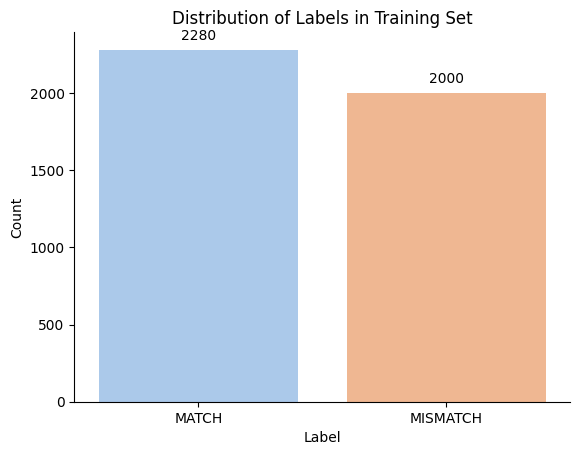

In [143]:
ax = sns.countplot(data=train_df, x='Label', hue='Label', palette='pastel')
plt.title('Distribution of Labels in Training Set')
plt.xlabel('Label')
plt.ylabel('Count')
sns.despine()

# add the values on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

In [144]:
train_df['Generated By'].value_counts()

Generated By
ChatGPT-4.1              2012
random_mismatch_logic    1027
hard_mismatch_logic       973
Gemini 1.5 Pro            268
Name: count, dtype: int64

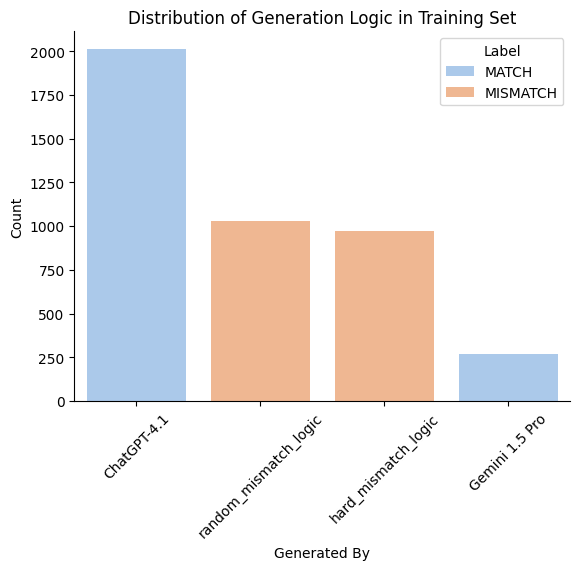

In [147]:
ax = sns.countplot(data=train_df, x='Generated By', hue='Label', palette='pastel')
plt.title('Distribution of Generation Logic in Training Set')
plt.xlabel('Generated By')
plt.ylabel('Count')

# rotate the x label by 45 degree
plt.xticks(rotation=45)

sns.despine()

# 4. Models

## Supervised Learning Baseline with XGBoost & TF-IDF Vectorizer

In [13]:
# returning just the descriptor & the merchant name in string format
def preprocess(df):
    return df["Messy Descriptor"].astype(str), df["Merchant Name"].astype(str)

# Extract X and y
X_train_desc, X_train_merchant = preprocess(train_df)
X_val_desc, X_val_merchant = preprocess(val_df)
X_test_desc, X_test_merchant = preprocess(test_df)

y_train = train_df["Label"].map({'MATCH': 1, 'MISMATCH': 0})
y_val = val_df["Label"].map({'MATCH': 1, 'MISMATCH': 0})
y_test = test_df["Label"].map({'MATCH': 1, 'MISMATCH': 0})

In [14]:
type(X_train_desc)

pandas.core.series.Series

In [15]:
type(X_train_merchant)

pandas.core.series.Series

In [16]:
type(y_train)

pandas.core.series.Series

### Term Frequency - Invese Document Frequency (TF-IDF) Vectorizer

In [18]:
# tf-idf will have unigrams + bigrams (1,2)
tfidf_desc = TfidfVectorizer(ngram_range=(1,2), max_features=5000)
tfidf_merchant = TfidfVectorizer(ngram_range=(1,2), max_features=5000)

#### Fit & Transform on X_train

In [19]:
X_train_desc_vec = tfidf_desc.fit_transform(X_train_desc)
X_train_merchant_vec = tfidf_merchant.fit_transform(X_train_merchant)
X_train_vec = hstack([X_train_desc_vec, X_train_merchant_vec])

In [20]:
X_train_vec.data[0:10]

array([0.42071631, 0.25252697, 0.20408388, 0.43589157, 0.43589157,
       0.38415272, 0.43589157, 0.46939793, 0.46939793, 0.29961444])

#### Transform on X_val & X_test

In [21]:
X_val_desc_vec = tfidf_desc.transform(X_val_desc)
X_val_merchant_vec = tfidf_merchant.transform(X_val_merchant)
X_val_vec = hstack([X_val_desc_vec, X_val_merchant_vec])

X_test_desc_vec = tfidf_desc.transform(X_test_desc)
X_test_merchant_vec = tfidf_merchant.transform(X_test_merchant)
X_test_vec = hstack([X_test_desc_vec, X_test_merchant_vec])

#### Save TF-IDF Vectors 

In [22]:
joblib.dump(tfidf_desc, './models/tfidf_descriptor_vectorizer.pkl')
joblib.dump(tfidf_merchant, './models/tfidf_merchant_vectorizer.pkl')

['./models/tfidf_merchant_vectorizer.pkl']

#### Load TF-IDF Vectors

In [20]:
tfidf_desc = joblib.load('./models/tfidf_descriptor_vectorizer.pkl')
tfidf_merchant = joblib.load('./models/tfidf_merchant_vectorizer.pkl')

### XGBoost Model #1

In [159]:
# XGBoost Model
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=1.0, # L2 regularization
    use_label_encoder=False, 
    eval_metric="logloss")

In [160]:
%time
xgb.fit(X_train_vec, y_train)

CPU times: user 5 μs, sys: 3 μs, total: 8 μs
Wall time: 27.9 μs


[11:46:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

#### Evaluating XGBoost #1

In [162]:
y_train_pred = xgb.predict(X_train_vec)
print("Training Evaluation Results:\n", classification_report(y_train, y_train_pred))

Training Evaluation Results:
               precision    recall  f1-score   support

           0       0.85      0.77      0.81      2000
           1       0.81      0.88      0.84      2280

    accuracy                           0.83      4280
   macro avg       0.83      0.82      0.82      4280
weighted avg       0.83      0.83      0.83      4280



In [ ]:
# Evaluation of validation set
y_val_pred = xgb.predict(X_val_vec)
print("Validation Results:\n", classification_report(y_val, y_val_pred))

Validation Results:
               precision    recall  f1-score   support

           0       0.66      0.53      0.59       250
           1       0.65      0.76      0.70       285

    accuracy                           0.65       535
   macro avg       0.65      0.64      0.64       535
weighted avg       0.65      0.65      0.65       535



In [163]:
# Evaluation of test set
y_test_pred = xgb.predict(X_test_vec)
print("Test Results:\n", classification_report(y_test, y_test_pred))

Test Results:
               precision    recall  f1-score   support

           0       0.66      0.56      0.61       250
           1       0.66      0.75      0.70       285

    accuracy                           0.66       535
   macro avg       0.66      0.66      0.66       535
weighted avg       0.66      0.66      0.66       535



Our model performs well on the training set (83% accuracy), but there's a clear gap on validation and test sets (~66% accuracy), suggesting overfitting.

### XGBoost Model #2 (Hyper-Parameter Tuned)

In [ ]:
params = {
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'n_estimators': [100, 300]
}

In [167]:
xgb_2 = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

In [170]:
grid = GridSearchCV(xgb_2, param_grid=params, scoring='f1', cv=3, verbose=1, n_jobs=1)
grid.fit(X_train_vec, y_train)
print("Best Parameters:", grid.best_params_)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[12:08:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[12:08:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[12:08:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[12:08:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[12:08:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[12:08:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[12:08:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[12:08:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" }

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.8}


In [174]:
# Step 2: Train with best params and track training loss
best_xgb = grid.best_estimator_

evals_result = {}
best_xgb.fit(
    X_train_vec, y_train,
    eval_set=[(X_train_vec, y_train), (X_val_vec, y_val)],
    # eval_metric='logloss', # no need for this as it is already specified before the GridSearch CV
    verbose=True,
    # evals_result=evals_result 
)

[0]	validation_0-logloss:0.69039	validation_1-logloss:0.69088
[1]	validation_0-logloss:0.68981	validation_1-logloss:0.69062
[2]	validation_0-logloss:0.68921	validation_1-logloss:0.69016
[3]	validation_0-logloss:0.68874	validation_1-logloss:0.68993
[4]	validation_0-logloss:0.68814	validation_1-logloss:0.68958
[5]	validation_0-logloss:0.68765	validation_1-logloss:0.68940


[12:14:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



[6]	validation_0-logloss:0.68703	validation_1-logloss:0.68900
[7]	validation_0-logloss:0.68650	validation_1-logloss:0.68885
[8]	validation_0-logloss:0.68597	validation_1-logloss:0.68848
[9]	validation_0-logloss:0.68538	validation_1-logloss:0.68815
[10]	validation_0-logloss:0.68490	validation_1-logloss:0.68798
[11]	validation_0-logloss:0.68442	validation_1-logloss:0.68776
[12]	validation_0-logloss:0.68396	validation_1-logloss:0.68760
[13]	validation_0-logloss:0.68338	validation_1-logloss:0.68714
[14]	validation_0-logloss:0.68295	validation_1-logloss:0.68697
[15]	validation_0-logloss:0.68242	validation_1-logloss:0.68677
[16]	validation_0-logloss:0.68189	validation_1-logloss:0.68652
[17]	validation_0-logloss:0.68141	validation_1-logloss:0.68617
[18]	validation_0-logloss:0.68084	validation_1-logloss:0.68559
[19]	validation_0-logloss:0.68029	validation_1-logloss:0.68536
[20]	validation_0-logloss:0.67980	validation_1-logloss:0.68516
[21]	validation_0-logloss:0.67940	validation_1-logloss:0.68

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [175]:
# Now accessing the eval results
evals_result = best_xgb.evals_result_

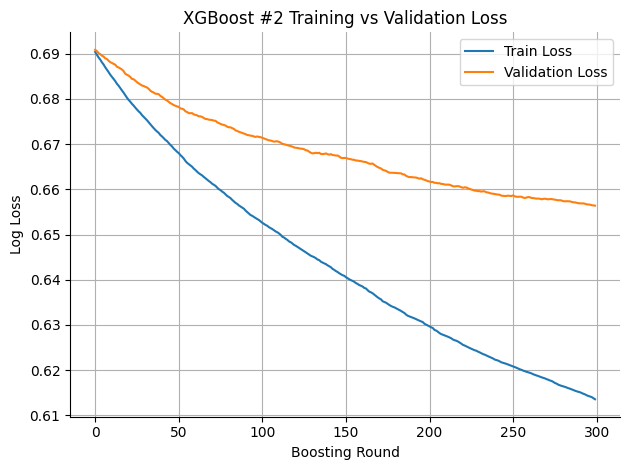

In [178]:
# Step 3: Plot loss
epochs = range(len(evals_result['validation_0']['logloss']))
plt.plot(epochs, evals_result['validation_0']['logloss'], label='Train Loss')
plt.plot(epochs, evals_result['validation_1']['logloss'], label='Validation Loss')
plt.xlabel("Boosting Round")
plt.ylabel("Log Loss")
plt.title("XGBoost #2 Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
sns.despine()

#### Evaluating XGBoost #2

In [179]:
y_train_pred = best_xgb.predict(X_train_vec)
print("XGBoost Model #2: \nTraining Evaluation Results:\n", classification_report(y_train, y_train_pred))

XGBoost Model #2: 
Training Evaluation Results:
               precision    recall  f1-score   support

           0       0.83      0.42      0.56      2000
           1       0.64      0.92      0.76      2280

    accuracy                           0.69      4280
   macro avg       0.74      0.67      0.66      4280
weighted avg       0.73      0.69      0.66      4280



In [180]:
# Evaluation of validation set
y_val_pred = best_xgb.predict(X_val_vec)
print("Validation Results:\n", classification_report(y_val, y_val_pred))

Validation Results:
               precision    recall  f1-score   support

           0       0.71      0.34      0.46       250
           1       0.60      0.88      0.72       285

    accuracy                           0.63       535
   macro avg       0.66      0.61      0.59       535
weighted avg       0.65      0.63      0.60       535



In [181]:
# Evaluation of test set
y_test_pred = best_xgb.predict(X_test_vec)
print("Test Results:\n", classification_report(y_test, y_test_pred))

Test Results:
               precision    recall  f1-score   support

           0       0.74      0.38      0.51       250
           1       0.62      0.88      0.73       285

    accuracy                           0.65       535
   macro avg       0.68      0.63      0.62       535
weighted avg       0.68      0.65      0.63       535



#### Saving XGBoost Model #2

In [184]:
joblib.dump(best_xgb, './models/xgb_baseline_model.pkl')

['./models/xgb_baseline_model.pkl']

#### Loading XGBoost Model #2

In [21]:
best_xgb = joblib.load('./models/xgb_baseline_model.pkl')

## LLMs for MATCH/MISMATCH Classification

### Zero Shot Prompting

In [22]:
def classify_with_ollama(desc, merchant, model='gemma3'):
    prompt = f"""
Given the messy transaction descriptor and the merchant name below, predict whether they represent the same entity (MATCH) or not (MISMATCH).

Messy Descriptor: {desc}
Merchant Name: {merchant}

Respond with only one word: MATCH or MISMATCH.
"""
    try:
        response = ollama.chat(model=model, messages=[{"role": "user", "content": prompt}])
        return response['message']['content'].strip().upper()
    except Exception as e:
        print("Error:", e)
        return "ERROR"

The above method was used initially. However to be able to reuse this in a better way, I have taken the prompt as a parameter. This way the same method can be used when I perform zero-shot, and few-shot promopting.

In [23]:
def classify_with_ollama(prompt, model='gemma3'):
    try:
        response = ollama.chat(model=model, messages=[{"role": "user", "content": prompt}])
        return response['message']['content'].strip().upper()
    except Exception as e:
        print("Error:", e)
        return "ERROR"

#### Gemma 3

In [25]:
classify_with_ollama("EBAY HOME-GDS US*", "Subway Store Ottawa", "gemma3")

'MISMATCH'

The above is correct.

In [28]:
classify_with_ollama("AMZNMKTP#123-CAN", "Amazing Mart Canada", model='gemma3')

'MATCH'

The above is incorrect as this transaction corresponds to Amazon Marketplace Canada.

In [200]:
llm_train_preds = []

for _, row in tqdm(train_df.iterrows(), total=len(train_df)):
    result = classify_with_ollama(row['Messy Descriptor'], row['Merchant Name'], model='gemma3')
    # Clean & fallback
    if result not in ['MATCH', 'MISMATCH']:
        result = 'MISMATCH'
    llm_train_preds.append(1 if result == 'MATCH' else 0)

100%|██████████| 4280/4280 [18:09<00:00,  3.93it/s]


In [203]:
print("Gemma3 LLM Evaluation on Train Set:")
print(classification_report(y_train, llm_train_preds))

Gemma3 LLM Evaluation on Train Set:
              precision    recall  f1-score   support

           0       1.00      0.52      0.68      2000
           1       0.70      1.00      0.83      2280

    accuracy                           0.78      4280
   macro avg       0.85      0.76      0.75      4280
weighted avg       0.84      0.78      0.76      4280



In [ ]:
llm_val_preds = []

for _, row in tqdm(val_df.iterrows(), total=len(val_df)):
    result = classify_with_ollama(row['Messy Descriptor'], row['Merchant Name'], model='gemma3')
    # Clean & fallback
    if result not in ['MATCH', 'MISMATCH']:
        result = 'MISMATCH'
    llm_val_preds.append(1 if result == 'MATCH' else 0)

100%|██████████| 535/535 [02:21<00:00,  3.77it/s]


In [206]:
print("Gemma3 LLM Evaluation on Validation Set:")
print(classification_report(y_val, llm_val_preds))

Gemma3 LLM Evaluation on Validation Set:
              precision    recall  f1-score   support

           0       0.99      0.54      0.70       250
           1       0.71      1.00      0.83       285

    accuracy                           0.79       535
   macro avg       0.85      0.77      0.77       535
weighted avg       0.84      0.79      0.77       535



In [207]:
llm_test_preds = []

for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    result = classify_with_ollama(row['Messy Descriptor'], row['Merchant Name'], model='gemma3')
    # Clean & fallback
    if result not in ['MATCH', 'MISMATCH']:
        result = 'MISMATCH'
    llm_test_preds.append(1 if result == 'MATCH' else 0)

100%|██████████| 535/535 [02:19<00:00,  3.84it/s]


In [208]:
print("Gemma3 LLM Evaluation on Test Set:")
print(classification_report(y_test, llm_test_preds))

Gemma3 LLM Evaluation on Test Set:
              precision    recall  f1-score   support

           0       1.00      0.48      0.65       250
           1       0.69      1.00      0.82       285

    accuracy                           0.76       535
   macro avg       0.84      0.74      0.73       535
weighted avg       0.83      0.76      0.74       535



#### Llama 3.2

In [26]:
classify_with_ollama("EBAY HOME-GDS US*", "Subway Store Ottawa", model='llama3.2')

'MISMATCH.'

In [27]:
classify_with_ollama("AMZNMKTP#123-CAN", "Amazing Mart Canada", model='llama3.2')

'MATCH.'

In [30]:
llm_train_preds = []

for _, row in tqdm(train_df.iterrows(), total=len(train_df)):
    prompt = f"""
Given the messy transaction descriptor and the merchant name below, predict whether they represent the same entity (MATCH) or not (MISMATCH).

Messy Descriptor: {row['Messy Descriptor']}
Merchant Name: {row['Merchant Name']}

Respond with only one word: MATCH or MISMATCH.
"""
    result = classify_with_ollama(prompt, model='llama3.2')
    # Clean & fallback
    if result not in ['MATCH', 'MISMATCH']:
        result = 'MISMATCH'
    llm_train_preds.append(1 if result == 'MATCH' else 0)

100%|██████████| 4280/4280 [13:12<00:00,  5.40it/s]


In [31]:
print("Llama3.2 LLM Evaluation (w/ Zero Shot Prompting) on Train Set:")
print(classification_report(y_train, llm_train_preds))

Llama3.2 LLM Evaluation (w/ Zero Shot Prompting) on Train Set:
              precision    recall  f1-score   support

           0       0.47      0.98      0.63      2000
           1       0.58      0.03      0.05      2280

    accuracy                           0.47      4280
   macro avg       0.52      0.50      0.34      4280
weighted avg       0.53      0.47      0.32      4280



In [32]:
llm_train_preds = []

for _, row in tqdm(val_df.iterrows(), total=len(val_df)):
    prompt = f"""
Given the messy transaction descriptor and the merchant name below, predict whether they represent the same entity (MATCH) or not (MISMATCH).

Messy Descriptor: {row['Messy Descriptor']}
Merchant Name: {row['Merchant Name']}

Respond with only one word: MATCH or MISMATCH.
"""
    result = classify_with_ollama(prompt, model='llama3.2')
    # Clean & fallback
    if result not in ['MATCH', 'MISMATCH']:
        result = 'MISMATCH'
    llm_train_preds.append(1 if result == 'MATCH' else 0)

100%|██████████| 535/535 [01:37<00:00,  5.47it/s]


In [33]:
print("Llama3.2 LLM Evaluation (w/ Zero Shot Prompting) on Validation Set:")
print(classification_report(y_val, llm_train_preds))

Llama3.2 LLM Evaluation (w/ Zero Shot Prompting) on Validation Set:
              precision    recall  f1-score   support

           0       0.46      0.97      0.63       250
           1       0.42      0.02      0.03       285

    accuracy                           0.46       535
   macro avg       0.44      0.49      0.33       535
weighted avg       0.44      0.46      0.31       535



In [34]:
llm_train_preds = []

for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    prompt = f"""
Given the messy transaction descriptor and the merchant name below, predict whether they represent the same entity (MATCH) or not (MISMATCH).

Messy Descriptor: {row['Messy Descriptor']}
Merchant Name: {row['Merchant Name']}

Respond with only one word: MATCH or MISMATCH.
"""
    result = classify_with_ollama(prompt, model='llama3.2')
    # Clean & fallback
    if result not in ['MATCH', 'MISMATCH']:
        result = 'MISMATCH'
    llm_train_preds.append(1 if result == 'MATCH' else 0)

100%|██████████| 535/535 [01:38<00:00,  5.41it/s]


In [35]:
print("Llama3.2 LLM Evaluation (w/ Zero Shot Prompting) on Test Set:")
print(classification_report(y_test, llm_train_preds))

Llama3.2 LLM Evaluation (w/ Zero Shot Prompting) on Test Set:
              precision    recall  f1-score   support

           0       0.47      0.98      0.64       250
           1       0.64      0.03      0.06       285

    accuracy                           0.47       535
   macro avg       0.56      0.51      0.35       535
weighted avg       0.56      0.47      0.33       535



### 20-Shot Prompting

One method to get better results from LLMs are to use 'Few-Shot' prompting approach. Let's try to find an optimal value 'x' that yields the best results while performing few-shot prompting.

Starting off with 20-Shot Prompting where we have 10 MATCH & 10 MISMATCH examples.

In [14]:
# starting with 10 examples for MATCH & 10 examples for mismatch
human_gen_df = pd.read_csv('./data/human_generated_merchant_data.csv')

In [15]:
human_gen_df

,Messy Descriptor,Merchant Name,Label,Generated By
0,WLMRT#001-OTTAWA,Walmart Ottawa Store 001,MATCH,Humans
1,MCD-ST234-VAN,McDonald's Vancouver Store 234,MATCH,Humans
2,AMZN Mktp CA*UC33G2023,Amazon Canada Marketplace,MATCH,Humans
3,UBR-LAX-RIDE#456,Uber Ride Los Angeles,MATCH,Humans
4,T-HRTNS#450-TOR,Tim Hortons Toronto Store 450,MATCH,Humans
5,XYZ123-TKN.BILL.PAY,Token Payments Ltd.,MATCH,Humans
6,TRVL123#WEB.PYMNT,Travel Inc. Online Payments,MATCH,Humans
7,A12B34-FIN-TXNS,Finance Transactions Co.,MATCH,Humans
8,PPL#99-WEB-TFR,PayPal Transfer,MATCH,Humans
9,BMS*SERVICE-FEE01,Billing Management Systems,MATCH,Humans


From the above, we can see that we have 20 different examples of MATCH & MISMATCH. We can feed this into the prompt and again ask the LLM to perform classification.

In [16]:
header = "Messy Descriptor | Merchant Name | Label"
rows = [
    f"{row['Messy Descriptor']} | {row['Merchant Name']} | {row['Label']}"
    for _, row in human_gen_df.iterrows()
]
ten_shot_prompt_str = "\n".join([header] + rows)
print(ten_shot_prompt_str)

Messy Descriptor | Merchant Name | Label
WLMRT#001-OTTAWA | Walmart Ottawa Store 001 | MATCH
MCD-ST234-VAN | McDonald's Vancouver Store 234 | MATCH
AMZN Mktp CA*UC33G2023 | Amazon Canada Marketplace | MATCH
UBR-LAX-RIDE#456 | Uber Ride Los Angeles | MATCH
T-HRTNS#450-TOR | Tim Hortons Toronto Store 450 | MATCH
XYZ123-TKN.BILL.PAY | Token Payments Ltd. | MATCH
TRVL123#WEB.PYMNT | Travel Inc. Online Payments | MATCH
A12B34-FIN-TXNS | Finance Transactions Co. | MATCH
PPL#99-WEB-TFR | PayPal Transfer | MATCH
BMS*SERVICE-FEE01 | Billing Management Systems | MATCH
AMZN Mktp CA*871PG7QT3 | Amazing Mart Canada | MISMATCH
STRBCKS#001-TOR | Star Books Toronto | MISMATCH
UBR-TRP123-LAX | Urban Transport LA | MISMATCH
T-HRTNS-ST50-EDM | Tom's Hardware Edmonton | MISMATCH
DELTA#456-US | Delta Equipment Co. | MISMATCH
PPL*TFR99-US | People Transfers LLC | MISMATCH
TRVL#567-WEB | Treville Web Services | MISMATCH
NETFLX#999-USA | NetFlex Gym USA | MISMATCH
SHELL#123-VAN | Shellfish Cafe Vancouver | MI

#### Gemma 3

In [20]:
llm_train_preds = []

for _, row in tqdm(train_df.iterrows(), total=len(train_df)):
    prompt = f"""
Below are examples of transaction descriptor and merchant name pairs. Your task is to determine whether each pair refers to the same entity or not.

Examples:
{ten_shot_prompt_str}

Now classify this pair:
Messy Descriptor: {row['Messy Descriptor']}
Merchant Name: {row['Merchant Name']}
Label: ?

Respond with only one word: MATCH or MISMATCH.
"""
    result = classify_with_ollama(prompt, model='gemma3')
    # Clean & fallback
    if result not in ['MATCH', 'MISMATCH']:
        result = 'MISMATCH'
    llm_train_preds.append(1 if result == 'MATCH' else 0)

100%|██████████| 4280/4280 [17:19<00:00,  4.12it/s]


In [21]:
print("Gemma3 LLM Evaluation (w/ 10-Shot Prompting) on Train Set:")
print(classification_report(y_train, llm_train_preds))

Gemma3 LLM Evaluation (w/ 10-Shot Prompting) on Train Set:
              precision    recall  f1-score   support

           0       0.88      0.68      0.77      2000
           1       0.76      0.92      0.84      2280

    accuracy                           0.81      4280
   macro avg       0.82      0.80      0.80      4280
weighted avg       0.82      0.81      0.80      4280



In [24]:
llm_train_preds = []

for _, row in tqdm(val_df.iterrows(), total=len(val_df)):
    prompt = f"""
Below are examples of transaction descriptor and merchant name pairs. Your task is to determine whether each pair refers to the same entity or not.

Examples:
{ten_shot_prompt_str}

Now classify this pair:
Messy Descriptor: {row['Messy Descriptor']}
Merchant Name: {row['Merchant Name']}
Label: ?

Respond with only one word: MATCH or MISMATCH.
"""
    result = classify_with_ollama(prompt, model='gemma3')
    # Clean & fallback
    if result not in ['MATCH', 'MISMATCH']:
        result = 'MISMATCH'
    llm_train_preds.append(1 if result == 'MATCH' else 0)

100%|██████████| 535/535 [02:10<00:00,  4.11it/s]


In [25]:
print("Gemma3 LLM Evaluation (w/ 10-Shot Prompting) on Validation Set:")
print(classification_report(y_val, llm_train_preds))

Gemma3 LLM Evaluation (w/ 10-Shot Prompting) on Validation Set:
              precision    recall  f1-score   support

           0       0.88      0.68      0.76       250
           1       0.76      0.92      0.83       285

    accuracy                           0.80       535
   macro avg       0.82      0.80      0.80       535
weighted avg       0.82      0.80      0.80       535



In [26]:
llm_train_preds = []

for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    prompt = f"""
Below are examples of transaction descriptor and merchant name pairs. Your task is to determine whether each pair refers to the same entity or not.

Examples:
{ten_shot_prompt_str}

Now classify this pair:
Messy Descriptor: {row['Messy Descriptor']}
Merchant Name: {row['Merchant Name']}
Label: ?

Respond with only one word: MATCH or MISMATCH.
"""
    result = classify_with_ollama(prompt, model='gemma3')
    # Clean & fallback
    if result not in ['MATCH', 'MISMATCH']:
        result = 'MISMATCH'
    llm_train_preds.append(1 if result == 'MATCH' else 0)

100%|██████████| 535/535 [02:06<00:00,  4.23it/s]


In [27]:
print("Gemma3 LLM Evaluation (w/ 10-Shot Prompting) on Test Set:")
print(classification_report(y_test, llm_train_preds))

Gemma3 LLM Evaluation (w/ 10-Shot Prompting) on Test Set:
              precision    recall  f1-score   support

           0       0.87      0.63      0.73       250
           1       0.74      0.92      0.82       285

    accuracy                           0.78       535
   macro avg       0.80      0.77      0.77       535
weighted avg       0.80      0.78      0.78       535



#### Llama 3.2

In [22]:
llm_train_preds = []

for _, row in tqdm(train_df.iterrows(), total=len(train_df)):
    prompt = f"""
Below are examples of transaction descriptor and merchant name pairs. Your task is to determine whether each pair refers to the same entity or not.

Examples:
{ten_shot_prompt_str}

Now classify this pair:
Messy Descriptor: {row['Messy Descriptor']}
Merchant Name: {row['Merchant Name']}
Label: ?

Respond with only one word: MATCH or MISMATCH.
"""
    result = classify_with_ollama(prompt, model='llama3.2')
    # Clean & fallback
    if result not in ['MATCH', 'MISMATCH']:
        result = 'MISMATCH'
    llm_train_preds.append(1 if result == 'MATCH' else 0)

100%|██████████| 4280/4280 [14:58<00:00,  4.77it/s]


In [23]:
print("Llama3.2 LLM Evaluation (w/ 10-Shot Prompting) on Train Set:")
print(classification_report(y_train, llm_train_preds))

Llama3.2 LLM Evaluation (w/ 10-Shot Prompting) on Train Set:
              precision    recall  f1-score   support

           0       0.48      0.94      0.64      2000
           1       0.69      0.11      0.19      2280

    accuracy                           0.50      4280
   macro avg       0.58      0.53      0.41      4280
weighted avg       0.59      0.50      0.40      4280



### Most Relevant Few-Shot Prompting: RAG approach w/ BGE Embedding + FAISS

The above 10-shot prompting technique could be potentially better than zero-shot prompting in many cases. However, the examples that we provide to the prompt are very important. Sometimes some of these examples are irrelevant to the current record being classified. This could confuse the model or lead to poor performance. To tackle this problem, I have decided to update each prompt by using the most relevant examples based on the record being classified.

Here is how we can do this using Retrieval Augmented Generation style:
1. store the labeled examples from the training set in a vector store
2. save the vectors in a FAISS index 
3. retrieve the K-most similar examples (based on the provided merchant descriptor & merchant)
4. update the prompt with only relevant examples
5. get the classification result from gemma/ llama

#### Embedding using Sentence Transformer

In [24]:
embedder = SentenceTransformer("BAAI/bge-base-en-v1.5")

In [25]:
# For queries and retrieval we prepend the following instruction
def format_bge(text):
    return f"Represent this sentence for retrieval: {text}"

In [26]:
# Combine descriptor + merchant
train_df['Descriptor_Merchant_Combined'] = (
    "Descriptor: " + train_df['Messy Descriptor'] +
    " | Merchant: " + train_df['Merchant Name']
)

# Format for BGE
formatted_corpus = train_df['Descriptor_Merchant_Combined'].apply(format_bge).tolist()

# Generate embeddings
corpus_embeddings = embedder.encode(formatted_corpus, normalize_embeddings=True, show_progress_bar=True)

Batches:   0%|          | 0/134 [00:00<?, ?it/s]

In [27]:
corpus_embeddings[0:5]

array([[-0.03799981, -0.02528429,  0.00026254, ...,  0.05331069,
         0.03482609,  0.03284325],
       [-0.02675174, -0.05389199,  0.05664716, ...,  0.02764655,
         0.03341817,  0.02519526],
       [-0.0427658 , -0.00755078, -0.01681873, ...,  0.03993357,
         0.00398077,  0.05109741],
       [-0.0440731 , -0.0332039 ,  0.01218131, ..., -0.00600278,
         0.01954629,  0.00577227],
       [-0.0542826 , -0.00265979, -0.00158635, ...,  0.00808312,
         0.00947689,  0.06205387]], dtype=float32)

In [28]:
corpus_embeddings.shape

(4280, 768)

#### Storing Embeddings in a FAISS Index

In [29]:
dimension = corpus_embeddings.shape[1]
index = faiss.IndexFlatIP(dimension)  # Inner product because embeddings are normalized
index.add(np.array(corpus_embeddings))

In [30]:
# Keeping a copy of the examples for lookup
example_lookup = train_df.reset_index(drop=True)

In [76]:
example_lookup.head()

,Messy Descriptor,Merchant Name,Label,Generated By,Descriptor_Merchant_Combined
0,RedLobstr-TOR CAN 878,Red Lobster Toronto,MATCH,ChatGPT-4.1,Descriptor: RedLobstr-TOR CAN 878 | Merchant: ...
1,BPSTATION*CLGRY CA,PayPal Services USA,MISMATCH,random_mismatch_logic,Descriptor: BPSTATION*CLGRY CA | Merchant: Pay...
2,BP GAS STN SEATL*5099,BP Gas Station Seattle,MATCH,ChatGPT-4.1,Descriptor: BP GAS STN SEATL*5099 | Merchant: ...
3,ChicagoUBER Ride*,Uber Ride Chicago,MATCH,ChatGPT-4.1,Descriptor: ChicagoUBER Ride* | Merchant: Uber...
4,LANDMARK*CNEMA WPG#51,Uber Ride Denver,MISMATCH,hard_mismatch_logic,Descriptor: LANDMARK*CNEMA WPG#51 | Merchant: ...


#### Retrieve 'k' Closest Matches Per Query

In [31]:
# defining a retriever & prompting method
def retrieve_examples(query_descriptor, query_merchant, top_k=5):
    query_text = f"Descriptor: {query_descriptor} | Merchant: {query_merchant}"
    query_embed = embedder.encode([format_bge(query_text)], normalize_embeddings=True)
    
    distances, indices = index.search(np.array(query_embed), top_k)
    return example_lookup.iloc[indices[0]]

In [32]:
# building the few shot prompt dynamically
def build_prompt(retrieved_df, query_descriptor, query_merchant):
    prompt = "You are given a transaction descriptor and a merchant name. Classify them as MATCH or MISMATCH.\n\nHere are some examples:\n"
    prompt += "----------------------------------------\n"
    
    for _, row in retrieved_df.iterrows():
        prompt += f"Descriptor: {row['Messy Descriptor']}\n"
        prompt += f"Merchant: {row['Merchant Name']}\n"
        prompt += f"Label: {row['Label']}\n"
    
    prompt += "----------------------------------------\n"
    prompt += "Now classify this pair:\n"
    prompt += f"Descriptor: {query_descriptor}\n"
    prompt += f"Merchant: {query_merchant}\n"
    prompt += "Label: ?\n"
    prompt += "Only return the label: MATCH or MISMATCH.\n"
    return prompt

#### Testing If This Works

In [33]:
# Test 1
# "EBAY HOME-GDS US*", "Subway Store Ottawa"

query_descriptor = "EBAY HOME-GDS US*"
query_merchant = "Subway Store Ottawa"

similar_examples = retrieve_examples(query_descriptor, query_merchant, top_k=10)

In [34]:
similar_examples

,Messy Descriptor,Merchant Name,Label,Generated By,Descriptor_Merchant_Combined
2494,EBAY HOME-GDS US*,Subway Store Ottawa,MISMATCH,random_mismatch_logic,Descriptor: EBAY HOME-GDS US* | Merchant: Subw...
861,EBAY HOME-GDS US*,eBay Home Goods US,MATCH,ChatGPT-4.1,Descriptor: EBAY HOME-GDS US* | Merchant: eBay...
4129,EBAY HOME-GDS US*,Uber Ride NYC,MISMATCH,random_mismatch_logic,Descriptor: EBAY HOME-GDS US* | Merchant: Uber...
947,EBAY COLLECTBL US*,McDonald's Ottawa Store 234,MISMATCH,random_mismatch_logic,Descriptor: EBAY COLLECTBL US* | Merchant: McD...
2119,USA OODS EBY*HOME,eBay Home Goods US,MISMATCH,hard_mismatch_logic,Descriptor: USA OODS EBY*HOME | Merchant: eBay...
1653,SUBWAY*STORE OTTAWA,Subway Store Ottawa,MATCH,ChatGPT-4.1,Descriptor: SUBWAY*STORE OTTAWA | Merchant: Su...
3859,SBWAY#STORE OTT,Subway Store Ottawa,MISMATCH,hard_mismatch_logic,Descriptor: SBWAY#STORE OTT | Merchant: Subway...
452,EB HOMEGOODS US 024,eBay Home Goods US,MISMATCH,hard_mismatch_logic,Descriptor: EB HOMEGOODS US 024 | Merchant: eB...
3126,OTTA.WA SBWAY#STOrE,Subway Store Ottawa,MISMATCH,hard_mismatch_logic,Descriptor: OTTA.WA SBWAY#STOrE | Merchant: Su...
2000,SUBWAY*STORE OTTAWA,Lowe's USA Retail,MISMATCH,random_mismatch_logic,Descriptor: SUBWAY*STORE OTTAWA | Merchant: Lo...


In [35]:
similar_10_prompt = build_prompt(similar_examples, query_descriptor, query_merchant)
print(similar_10_prompt)

You are given a transaction descriptor and a merchant name. Classify them as MATCH or MISMATCH.

Here are some examples:
----------------------------------------
Descriptor: EBAY HOME-GDS US*
Merchant: Subway Store Ottawa
Label: MISMATCH
Descriptor: EBAY HOME-GDS US*
Merchant: eBay Home Goods US
Label: MATCH
Descriptor: EBAY HOME-GDS US*
Merchant: Uber Ride NYC
Label: MISMATCH
Descriptor: EBAY COLLECTBL US*
Merchant: McDonald's Ottawa Store 234
Label: MISMATCH
Descriptor: USA OODS EBY*HOME
Merchant: eBay Home Goods US
Label: MISMATCH
Descriptor: SUBWAY*STORE OTTAWA
Merchant: Subway Store Ottawa
Label: MATCH
Descriptor: SBWAY#STORE OTT
Merchant: Subway Store Ottawa
Label: MISMATCH
Descriptor: EB HOMEGOODS US 024
Merchant: eBay Home Goods US
Label: MISMATCH
Descriptor: OTTA.WA SBWAY#STOrE
Merchant: Subway Store Ottawa
Label: MISMATCH
Descriptor: SUBWAY*STORE OTTAWA
Merchant: Lowe's USA Retail
Label: MISMATCH
----------------------------------------
Now classify this pair:
Descriptor: EBA

In [36]:
test_1__gemma_result = classify_with_ollama(similar_10_prompt, model='gemma3')
print(f"Gemma3: {query_descriptor} | {query_merchant} = {test_1__gemma_result}")

Gemma3: EBAY HOME-GDS US* | Subway Store Ottawa = MISMATCH


In [37]:
test_1_llama3_result = classify_with_ollama(similar_10_prompt, model='llama3.2')
print(f"Llama3.2: {query_descriptor} | {query_merchant} = {test_1_llama3_result}")

Llama3.2: EBAY HOME-GDS US* | Subway Store Ottawa = MATCH


The first test above shows all the steps working correctly as expected. We can also see that both the LLMs have generated 'MISMATCH' which is correct. Let's try another more tricky example:

In [38]:
# Test 2
# "AMZNMKTP#123-CAN", "Amazing Mart Canada"

query_descriptor = "AMZNMKTP#123-CAN"
query_merchant = "Amazing Mart Canada"

similar_examples = retrieve_examples(query_descriptor, query_merchant, top_k=10)

In [39]:
similar_examples

,Messy Descriptor,Merchant Name,Label,Generated By,Descriptor_Merchant_Combined
1750,AMZN.CAN SRVC #5678,Tim Hortons Florida Store,MISMATCH,random_mismatch_logic,Descriptor: AMZN.CAN SRVC #5678 | Merchant: Ti...
2856,AMZ H.OME GOODS*CAN/905#,Tim Hortons Ottawa Store,MISMATCH,hard_mismatch_logic,Descriptor: AMZ H.OME GOODS*CAN/905# | Merchan...
122,WALMART STORE#678-CAN,Walmart Canada Store 678,MATCH,ChatGPT-4.1,Descriptor: WALMART STORE#678-CAN | Merchant: ...
4113,AMZN.CAN SRVC #5678,Target Canada Online,MISMATCH,random_mismatch_logic,Descriptor: AMZN.CAN SRVC #5678 | Merchant: Ta...
2669,WALMART STOR#678-CAN,Walmart Canada Store 678,MISMATCH,hard_mismatch_logic,Descriptor: WALMART STOR#678-CAN | Merchant: W...
1290,AMZ HOME GOODS*CAN/905,Amazon Home Goods Canada,MATCH,ChatGPT-4.1,Descriptor: AMZ HOME GOODS*CAN/905 | Merchant:...
3008,WLMRT STORE678*CAN,Walmart Canada Store 678,MATCH,ChatGPT-4.1,Descriptor: WLMRT STORE678*CAN | Merchant: Wal...
2994,AMZN.CA SVCS-001,Tim Hortons Ottawa Store,MISMATCH,random_mismatch_logic,Descriptor: AMZN.CA SVCS-001 | Merchant: Tim H...
2174,AMZN.CAN SRVC #5678,Amazon Canada Services,MATCH,ChatGPT-4.1,Descriptor: AMZN.CAN SRVC #5678 | Merchant: Am...
1253,AMZON-CAN SVC*1234,Amazon Canada Services,MATCH,ChatGPT-4.1,Descriptor: AMZON-CAN SVC*1234 | Merchant: Ama...


It looks like out of the 100 examples we considered, there are not many transactions which are similar. 

In [40]:
similar_10_prompt = build_prompt(similar_examples, query_descriptor, query_merchant)
print(similar_10_prompt)

You are given a transaction descriptor and a merchant name. Classify them as MATCH or MISMATCH.

Here are some examples:
----------------------------------------
Descriptor: AMZN.CAN SRVC #5678
Merchant: Tim Hortons Florida Store
Label: MISMATCH
Descriptor: AMZ H.OME GOODS*CAN/905#
Merchant: Tim Hortons Ottawa Store
Label: MISMATCH
Descriptor: WALMART STORE#678-CAN
Merchant: Walmart Canada Store 678
Label: MATCH
Descriptor: AMZN.CAN SRVC #5678
Merchant: Target Canada Online
Label: MISMATCH
Descriptor: WALMART STOR#678-CAN
Merchant: Walmart Canada Store 678
Label: MISMATCH
Descriptor: AMZ HOME GOODS*CAN/905
Merchant: Amazon Home Goods Canada
Label: MATCH
Descriptor: WLMRT STORE678*CAN
Merchant: Walmart Canada Store 678
Label: MATCH
Descriptor: AMZN.CA SVCS-001
Merchant: Tim Hortons Ottawa Store
Label: MISMATCH
Descriptor: AMZN.CAN SRVC #5678
Merchant: Amazon Canada Services
Label: MATCH
Descriptor: AMZON-CAN SVC*1234
Merchant: Amazon Canada Services
Label: MATCH
------------------------

In [41]:
test_2_gemma_result = classify_with_ollama(similar_10_prompt, model='gemma3')
print(f"{query_descriptor} | {query_merchant} = {test_2_gemma_result}")

AMZNMKTP#123-CAN | Amazing Mart Canada = MISMATCH


In [42]:
test_2_llama_result = classify_with_ollama(similar_10_prompt, model='llama3.2')
print(f"{query_descriptor} | {query_merchant} = {test_2_llama_result}")

AMZNMKTP#123-CAN | Amazing Mart Canada = MISMATCH.


Surprisingly this worked! However, we can see that based on the retrieved examples, there was one example as displayed beloiw, which might have suggested the model to predict 'MISMATCH':

- US AMZN Mktplce | Amazon US Marketplace | MATCH

In [43]:
# Test 3
# "AMZNMKTP#123-CAN", "Amazing Mart Canada"

query_descriptor = "AMZN Mktp CA*UC33G2023"
query_merchant = "Amazon Canada Marketplace"

similar_examples = retrieve_examples(query_descriptor, query_merchant, top_k=10)

In [44]:
similar_examples

,Messy Descriptor,Merchant Name,Label,Generated By,Descriptor_Merchant_Combined
644,AMZN-MKTP US*USA,Amazon US Marketplace,MATCH,ChatGPT-4.1,Descriptor: AMZN-MKTP US*USA | Merchant: Amazo...
2933,AMZN MKTPLC US/1234,Amazon US Marketplace,MATCH,ChatGPT-4.1,Descriptor: AMZN MKTPLC US/1234 | Merchant: Am...
2537,AMZN US MKTPLC*,Amazon US Marketplace,MATCH,ChatGPT-4.1,Descriptor: AMZN US MKTPLC* | Merchant: Amazon...
2951,AMZN US MKTPL,Amazon US Marketplace,MATCH,Gemini 1.5 Pro,Descriptor: AMZN US MKTPL | Merchant: Amazon U...
2156,AMZ-MKTPLC US-01,Amazon US Marketplace,MATCH,ChatGPT-4.1,Descriptor: AMZ-MKTPLC US-01 | Merchant: Amazo...
1251,US AMZN Mktplce,Amazon US Marketplace,MATCH,Gemini 1.5 Pro,Descriptor: US AMZN Mktplce | Merchant: Amazon...
529,AMAZN US-MKTPL #45,Amazon US Marketplace,MATCH,ChatGPT-4.1,Descriptor: AMAZN US-MKTPL #45 | Merchant: Ama...
1747,AMZN*CNDA SRVCS-8732,Amazon Canada Services,MATCH,ChatGPT-4.1,Descriptor: AMZN*CNDA SRVCS-8732 | Merchant: A...
3767,AMZN.CA*SERVICES#1234,Amazon Canada Services,MATCH,ChatGPT-4.1,Descriptor: AMZN.CA*SERVICES#1234 | Merchant: ...
1512,AMZCAN*SERV 00233,Amazon Canada Services,MATCH,ChatGPT-4.1,Descriptor: AMZCAN*SERV 00233 | Merchant: Amaz...


In [45]:
similar_10_prompt = build_prompt(similar_examples, query_descriptor, query_merchant)
print(similar_10_prompt)

You are given a transaction descriptor and a merchant name. Classify them as MATCH or MISMATCH.

Here are some examples:
----------------------------------------
Descriptor: AMZN-MKTP US*USA
Merchant: Amazon US Marketplace
Label: MATCH
Descriptor: AMZN MKTPLC US/1234
Merchant: Amazon US Marketplace
Label: MATCH
Descriptor: AMZN US MKTPLC*
Merchant: Amazon US Marketplace
Label: MATCH
Descriptor: AMZN US MKTPL
Merchant: Amazon US Marketplace
Label: MATCH
Descriptor: AMZ-MKTPLC US-01
Merchant: Amazon US Marketplace
Label: MATCH
Descriptor: US AMZN Mktplce
Merchant: Amazon US Marketplace
Label: MATCH
Descriptor: AMAZN US-MKTPL #45
Merchant: Amazon US Marketplace
Label: MATCH
Descriptor: AMZN*CNDA SRVCS-8732
Merchant: Amazon Canada Services
Label: MATCH
Descriptor: AMZN.CA*SERVICES#1234
Merchant: Amazon Canada Services
Label: MATCH
Descriptor: AMZCAN*SERV 00233
Merchant: Amazon Canada Services
Label: MATCH
----------------------------------------
Now classify this pair:
Descriptor: AMZN Mkt

In [46]:
test_3_gemma_result = classify_with_ollama(similar_10_prompt, model='gemma3')
print(f"{query_descriptor} | {query_merchant} = {test_3_gemma_result}")

AMZN Mktp CA*UC33G2023 | Amazon Canada Marketplace = MATCH


In [47]:
test_3_llama_result = classify_with_ollama(similar_10_prompt, model='llama3.2')
print(f"{query_descriptor} | {query_merchant} = {test_3_llama_result}")

AMZN Mktp CA*UC33G2023 | Amazon Canada Marketplace = MISMATCH


Interestingly Llama3.2 model thinks that the amazon transaction is a mismatch, even though it is a match. The Gemma3 model correctly predicted that it is a MATCH. Gemma3 is showing better results so far.

Let's write a method that can do all these tasks in one method:

In [48]:
def classify_batch_with_rag(df, faiss_index, example_lookup, embedder, top_k=5, model_name="gemma3"):

    predictions = []
    true_labels = df["Label"].tolist()

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Classifying rows with RAG"):
        # Construct query
        descriptor = row["Messy Descriptor"]
        merchant = row["Merchant Name"]
        query_text = f"Descriptor: {descriptor} | Merchant: {merchant}"
        query_embed = embedder.encode(["Represent this sentence for retrieval: " + query_text], normalize_embeddings=True)

        # FAISS retrieval
        distances, indices = faiss_index.search(np.array(query_embed), top_k)
        retrieved_df = example_lookup.iloc[indices[0]]

        # Build prompt
        prompt = "You are given a transaction descriptor and a merchant name. Classify them as MATCH or MISMATCH.\n\nHere are some examples:\n"
        prompt += "----------------------------------------\n"
        for _, example_row in retrieved_df.iterrows():
            prompt += f"Descriptor: {example_row['Messy Descriptor']}\n"
            prompt += f"Merchant: {example_row['Merchant Name']}\n"
            prompt += f"Label: {example_row['Label']}\n\n"
        prompt += "----------------------------------------\n"
        prompt += "Now classify this pair:\n"
        prompt += f"Descriptor: {descriptor}\n"
        prompt += f"Merchant: {merchant}\nLabel: ?\n"
        prompt += "Only return the label: 'MATCH' or 'MISMATCH'.\n"

        # Get prediction from Ollama
        prediction = classify_with_ollama(prompt, model=model_name)

        predictions.append(prediction)

    return predictions, true_labels

#### Most Relevnt 5-Shot Prompting (RAG, FAISS)
##### Gemma 3

Let's see how this perfoms on train, val and test sets:

In [95]:
# checking performance of gemma on training set
example_lookup = train_df.reset_index(drop=True)
predictions, true_labels = classify_batch_with_rag(train_df, index, example_lookup, embedder, top_k=5, model_name="gemma3")

Classifying rows with RAG: 100%|██████████| 4280/4280 [39:06<00:00,  1.82it/s]


In [98]:
# classification report
print("Gemma3 RAG Evaluation Based on Relevant 5-Shot Prompt on Train Set:")
print(classification_report(true_labels, predictions))

Gemma3 RAG Evaluation Based on Relevant 5-Shot Prompt on Train Set:
              precision    recall  f1-score   support

       MATCH       0.70      0.99      0.82      2280
    MISMATCH       0.97      0.52      0.67      2000

    accuracy                           0.77      4280
   macro avg       0.83      0.75      0.75      4280
weighted avg       0.83      0.77      0.75      4280



In [102]:
# evaluating performance of gemma on validation set

# Combine descriptor + merchant
val_df['Descriptor_Merchant_Combined'] = (
    "Descriptor: " + val_df['Messy Descriptor'] +
    " | Merchant: " + val_df['Merchant Name']
)

# Format for BGE
formatted_corpus_val = val_df['Descriptor_Merchant_Combined'].apply(format_bge).tolist()

# Generate embeddings
corpus_embeddings_val = embedder.encode(formatted_corpus_val, normalize_embeddings=True, show_progress_bar=True)

index_val = faiss.IndexFlatIP(corpus_embeddings_val.shape[1])  # Inner product because embeddings are normalized
index_val.add(np.array(corpus_embeddings_val))

example_lookup_val = val_df.reset_index(drop=True)
predictions, true_labels = classify_batch_with_rag(val_df, index_val, example_lookup_val, embedder, top_k=5, model_name="gemma3")

Batches:   0%|          | 0/17 [00:00<?, ?it/s]

Classifying rows with RAG: 100%|██████████| 535/535 [04:51<00:00,  1.83it/s]


In [103]:
# classification report
print("Gemma3 RAG Evaluation Based on Relevant 5-Shot Prompt on Validation Set:")
print(classification_report(true_labels, predictions))

Gemma3 RAG Evaluation Based on Relevant 5-Shot Prompt on Validation Set:
              precision    recall  f1-score   support

       MATCH       0.73      0.99      0.84       285
    MISMATCH       0.98      0.58      0.73       250

    accuracy                           0.80       535
   macro avg       0.86      0.79      0.79       535
weighted avg       0.85      0.80      0.79       535



In [104]:
# evaluating performance of gemma on test set

# Combine descriptor + merchant
test_df['Descriptor_Merchant_Combined'] = (
    "Descriptor: " + test_df['Messy Descriptor'] +
    " | Merchant: " + test_df['Merchant Name']
)

# Format for BGE
formatted_corpus_test = test_df['Descriptor_Merchant_Combined'].apply(format_bge).tolist()

# Generate embeddings
corpus_embeddings_test = embedder.encode(formatted_corpus_test, normalize_embeddings=True, show_progress_bar=True)

index_val = faiss.IndexFlatIP(corpus_embeddings_test.shape[1])  # Inner product because embeddings are normalized
index_val.add(np.array(corpus_embeddings_test))

example_lookup_test = test_df.reset_index(drop=True)
predictions, true_labels = classify_batch_with_rag(test_df, index_val, example_lookup_test, embedder, top_k=5, model_name="gemma3")

Batches:   0%|          | 0/17 [00:00<?, ?it/s]

Classifying rows with RAG: 100%|██████████| 535/535 [04:48<00:00,  1.85it/s]


In [105]:
# classification report
print("Gemma3 RAG Evaluation Based on Relevant 5-Shot Prompt on Test Set:")
print(classification_report(true_labels, predictions))

Gemma3 RAG Evaluation Based on Relevant 5-Shot Prompt on Test Set:
              precision    recall  f1-score   support

       MATCH       0.74      1.00      0.85       285
    MISMATCH       0.99      0.60      0.75       250

    accuracy                           0.81       535
   macro avg       0.87      0.80      0.80       535
weighted avg       0.86      0.81      0.80       535



##### Llama 3.2

In [ ]:
# evaluating performance of gemma on training set

# Combine descriptor + merchant
train_df['Descriptor_Merchant_Combined'] = (
    "Descriptor: " + train_df['Messy Descriptor'] +
    " | Merchant: " + train_df['Merchant Name']
)

# Format for BGE
formatted_corpus_train = train_df['Descriptor_Merchant_Combined'].apply(format_bge).tolist()

# Generate embeddings
corpus_embeddings_val = embedder.encode(formatted_corpus_train, normalize_embeddings=True, show_progress_bar=True)

index = faiss.IndexFlatIP(corpus_embeddings_val.shape[1])  # Inner product because embeddings are normalized
index.add(np.array(corpus_embeddings_val))

example_lookup = train_df.reset_index(drop=True)
predictions, true_labels = classify_batch_with_rag(train_df, index, example_lookup, embedder, top_k=5, model_name="llama3.2")

Batches:   0%|          | 0/134 [00:00<?, ?it/s]

Classifying rows with RAG: 100%|██████████| 4280/4280 [33:57<00:00,  2.10it/s]  


In [113]:
# classification report
print("Llama 3.2 RAG Evaluation Based on Relevant 5-Shot Prompt on Train Set:")
print(classification_report(true_labels, predictions))

Llama 3.2 RAG Evaluation Based on Relevant 5-Shot Prompt on Train Set:
                                                                                                                                                                                                                                                                                                                  precision    recall  f1-score   support

                                                                                                                                                                                                                                                                                                    LABEL: MATCH       0.00      0.00      0.00         0
                                                                                                                                                                                                                                            

/opt/homebrew/anaconda3/envs/csye7230/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/csye7230/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/csye7230/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

In [ ]:
predictions

['MATCH.',
 'MISMATCH.',
 'MATCH',
 'MISMATCH.',
 'MATCH.',
 'MATCH.',
 'MISMATCH',
 'MATCH.',
 'MISMATCH.',
 'MATCH.',
 'MISMATCH.',
 "MISMATCH. THE ASTERISK (*) IS NOT PRESENT IN THE MERCHANT NAME AS IT'S SUPPOSED TO BE ACCORDING TO THE EXAMPLES PROVIDED.",
 'MATCH',
 'MISMATCH',
 'MATCH.',
 'MISMATCH',
 'MISMATCH',
 'MISMATCH.',
 'MISMATCH.',
 'MATCH',
 'MISMATCH.',
 'MATCH',
 'MISMATCH',
 'MISMATCH.',
 'MATCH.',
 'MATCH.',
 'MISMATCH',
 'MATCH.',
 'MISMATCH.',
 'MATCH.',
 'MATCH',
 'MISMATCH',
 'MISMATCH',
 'MISMATCH.',
 'MISMATCH.',
 'MATCH',
 'MATCH.',
 'MATCH.',
 'MATCH.',
 'MATCH.',
 'MISMATCH.',
 'MISMATCH',
 'MATCH.',
 'MISMATCH.',
 'MISMATCH.',
 'MISMATCH',
 'MISMATCH',
 'MATCH',
 'MISMATCH.',
 'MISMATCH.',
 'MATCH',
 'MISMATCH',
 'MATCH.',
 'MATCH.',
 'MISMATCH',
 'MISMATCH.',
 'MISMATCH.',
 'MISMATCH',
 'MATCH.',
 'MATCH.',
 'MATCH.',
 'MATCH.',
 'MATCH',
 'MISMATCH.',
 'MATCH',
 'MATCH.',
 'MISMATCH.',
 'MATCH.',
 'MATCH.',
 'MISMATCH.',
 'MATCH.',
 'MATCH.',
 'MATCH',
 '

In [49]:
def clean_prediction(response_text):
    response_text = response_text.upper()
    if "MISMATCH" in response_text:
        return "MISMATCH"
    elif "MATCH" in response_text:
        return "MATCH"
    return "UNKNOWN"

In [117]:
cleaned_predictions = [clean_prediction(prediction) for prediction in predictions]

In [119]:
cleaned_predictions

['MATCH',
 'MISMATCH',
 'MATCH',
 'MISMATCH',
 'MATCH',
 'MATCH',
 'MISMATCH',
 'MATCH',
 'MISMATCH',
 'MATCH',
 'MISMATCH',
 'MISMATCH',
 'MATCH',
 'MISMATCH',
 'MATCH',
 'MISMATCH',
 'MISMATCH',
 'MISMATCH',
 'MISMATCH',
 'MATCH',
 'MISMATCH',
 'MATCH',
 'MISMATCH',
 'MISMATCH',
 'MATCH',
 'MATCH',
 'MISMATCH',
 'MATCH',
 'MISMATCH',
 'MATCH',
 'MATCH',
 'MISMATCH',
 'MISMATCH',
 'MISMATCH',
 'MISMATCH',
 'MATCH',
 'MATCH',
 'MATCH',
 'MATCH',
 'MATCH',
 'MISMATCH',
 'MISMATCH',
 'MATCH',
 'MISMATCH',
 'MISMATCH',
 'MISMATCH',
 'MISMATCH',
 'MATCH',
 'MISMATCH',
 'MISMATCH',
 'MATCH',
 'MISMATCH',
 'MATCH',
 'MATCH',
 'MISMATCH',
 'MISMATCH',
 'MISMATCH',
 'MISMATCH',
 'MATCH',
 'MATCH',
 'MATCH',
 'MATCH',
 'MATCH',
 'MISMATCH',
 'MATCH',
 'MATCH',
 'MISMATCH',
 'MATCH',
 'MATCH',
 'MISMATCH',
 'MATCH',
 'MATCH',
 'MATCH',
 'MISMATCH',
 'MATCH',
 'MISMATCH',
 'MATCH',
 'MATCH',
 'MATCH',
 'MISMATCH',
 'MATCH',
 'MATCH',
 'MATCH',
 'MISMATCH',
 'MATCH',
 'MISMATCH',
 'MISMATCH',
 'MI

In [121]:
# classification report
print("Llama 3.2 RAG Evaluation Based on Relevant 5-Shot Prompt on Train Set:")
print(classification_report(true_labels, cleaned_predictions))

Llama 3.2 RAG Evaluation Based on Relevant 5-Shot Prompt on Train Set:
              precision    recall  f1-score   support

       MATCH       0.58      0.57      0.58      2280
    MISMATCH       0.52      0.54      0.53      2000

    accuracy                           0.56      4280
   macro avg       0.55      0.55      0.55      4280
weighted avg       0.56      0.56      0.56      4280



Surprisingly, the Llama 3.2 model does extremely badly compared to the Gemma. Let's see if the performance remains this bad even on the validation and test sets.

In [122]:
predictions, true_labels = classify_batch_with_rag(val_df, index_val, example_lookup_val, embedder, top_k=5, model_name="llama3.2")

Classifying rows with RAG: 100%|██████████| 535/535 [03:54<00:00,  2.28it/s]


In [125]:
predictions[:25]

['MISMATCH.',
 'MISMATCH',
 'MISMATCH.',
 'MATCH',
 'MISMATCH',
 'MISMATCH.',
 'MATCH',
 'MISMATCH',
 'MISMATCH.',
 'MATCH',
 'MISMATCH.',
 'MISMATCH',
 'MISMATCH.',
 'MISMATCH.',
 'MATCH.',
 'MISMATCH.',
 'MATCH',
 'MISMATCH.',
 'MISMATCH.',
 'MATCH',
 'MISMATCH',
 'MISMATCH.',
 'MISMATCH.',
 'MISMATCH.',
 'MISMATCH']

In [126]:
cleaned_predictions = [clean_prediction(prediction) for prediction in predictions]

In [127]:
cleaned_predictions[:25]

['MISMATCH',
 'MISMATCH',
 'MISMATCH',
 'MATCH',
 'MISMATCH',
 'MISMATCH',
 'MATCH',
 'MISMATCH',
 'MISMATCH',
 'MATCH',
 'MISMATCH',
 'MISMATCH',
 'MISMATCH',
 'MISMATCH',
 'MATCH',
 'MISMATCH',
 'MATCH',
 'MISMATCH',
 'MISMATCH',
 'MATCH',
 'MISMATCH',
 'MISMATCH',
 'MISMATCH',
 'MISMATCH',
 'MISMATCH']

In [128]:
# classification report
print("Llama 3.2 RAG Evaluation Based on Relevant 5-Shot Prompt on Validation Set:")
print(classification_report(true_labels, cleaned_predictions))

Llama 3.2 RAG Evaluation Based on Relevant 5-Shot Prompt on Validation Set:
              precision    recall  f1-score   support

       MATCH       0.65      0.22      0.33       285
    MISMATCH       0.49      0.86      0.63       250

    accuracy                           0.52       535
   macro avg       0.57      0.54      0.48       535
weighted avg       0.58      0.52      0.47       535



In [129]:
# evaluating performance of llama3.2 on test set

# Combine descriptor + merchant
test_df['Descriptor_Merchant_Combined'] = (
    "Descriptor: " + test_df['Messy Descriptor'] +
    " | Merchant: " + test_df['Merchant Name']
)

# Format for BGE
formatted_corpus_test = test_df['Descriptor_Merchant_Combined'].apply(format_bge).tolist()

# Generate embeddings
corpus_embeddings_test = embedder.encode(formatted_corpus_test, normalize_embeddings=True, show_progress_bar=True)

index_test = faiss.IndexFlatIP(corpus_embeddings_test.shape[1])  # Inner product because embeddings are normalized
index_test.add(np.array(corpus_embeddings_test))

example_lookup_test = test_df.reset_index(drop=True)
predictions, true_labels = classify_batch_with_rag(test_df, index_test, example_lookup_test, embedder, top_k=5, model_name="llama3.2")

Batches:   0%|          | 0/17 [00:00<?, ?it/s]

Classifying rows with RAG: 100%|██████████| 535/535 [03:51<00:00,  2.31it/s]


In [130]:
predictions[:25]

['MATCH.',
 'MISMATCH.',
 'MISMATCH.',
 'MISMATCH.',
 'MATCH.',
 'MISMATCH.',
 'MATCH.',
 'MATCH.',
 'MISMATCH',
 'MISMATCH.',
 'MATCH',
 'MATCH',
 'MATCH',
 'MISMATCH',
 'MATCH',
 'MATCH.',
 'MISMATCH.',
 'MATCH.',
 'MISMATCH',
 'MISMATCH',
 'MATCH',
 'MISMATCH.',
 'MATCH',
 'MISMATCH',
 'MATCH']

In [131]:
cleaned_predictions = [clean_prediction(prediction) for prediction in predictions]

In [132]:
# classification report
print("Llama 3.2 RAG Evaluation Based on Relevant 5-Shot Prompt on Test Set:")
print(classification_report(true_labels, cleaned_predictions))

Llama 3.2 RAG Evaluation Based on Relevant 5-Shot Prompt on Test Set:
              precision    recall  f1-score   support

       MATCH       0.65      0.68      0.67       285
    MISMATCH       0.62      0.59      0.60       250

    accuracy                           0.64       535
   macro avg       0.64      0.64      0.64       535
weighted avg       0.64      0.64      0.64       535



#### Most Relevnt 10-Shot Prompting (RAG, FAISS)
##### Gemma 3

In [ ]:
# evaluating performance of gemma on training set

# Combine descriptor + merchant
train_df['Descriptor_Merchant_Combined'] = (
    "Descriptor: " + train_df['Messy Descriptor'] +
    " | Merchant: " + train_df['Merchant Name']
)

# Format for BGE
formatted_corpus_train = train_df['Descriptor_Merchant_Combined'].apply(format_bge).tolist()

# Generate embeddings
corpus_embeddings_val = embedder.encode(formatted_corpus_train, normalize_embeddings=True, show_progress_bar=True)

index = faiss.IndexFlatIP(corpus_embeddings_val.shape[1])  # Inner product because embeddings are normalized
index.add(np.array(corpus_embeddings_val))

example_lookup = train_df.reset_index(drop=True)
predictions, true_labels = classify_batch_with_rag(train_df, index, example_lookup, embedder, top_k=10, model_name="gemma3")

Batches:   0%|          | 0/134 [00:00<?, ?it/s]

Classifying rows with RAG: 100%|██████████| 4280/4280 [56:47<00:00,  1.26it/s] 


In [107]:
# classification report
print("Gemma3 RAG Evaluation Based on Relevant 10-Shot Prompt on Training Set:")
print(classification_report(true_labels, predictions))

Gemma3 RAG Evaluation Based on Relevant 10-Shot Prompt on Training Set:
              precision    recall  f1-score   support

       MATCH       0.73      0.98      0.83      2280
    MISMATCH       0.96      0.58      0.72      2000

    accuracy                           0.79      4280
   macro avg       0.84      0.78      0.78      4280
weighted avg       0.83      0.79      0.78      4280



In [108]:
# evaluating 10-shot prompt performance on validation set
predictions, true_labels = classify_batch_with_rag(val_df, index_val, example_lookup_val, embedder, top_k=10, model_name="gemma3")

Classifying rows with RAG: 100%|██████████| 535/535 [07:12<00:00,  1.24it/s]


In [109]:
# classification report
print("Gemma3 RAG Evaluation Based on Relevant 10-Shot Prompt on Validation Set:")
print(classification_report(true_labels, predictions))

Gemma3 RAG Evaluation Based on Relevant 10-Shot Prompt on Validation Set:
              precision    recall  f1-score   support

       MATCH       0.77      0.84      0.81       285
    MISMATCH       0.80      0.72      0.76       250

    accuracy                           0.78       535
   macro avg       0.79      0.78      0.78       535
weighted avg       0.78      0.78      0.78       535



In [110]:
# evaluating performance of gemma on test set

# Combine descriptor + merchant
test_df['Descriptor_Merchant_Combined'] = (
    "Descriptor: " + test_df['Messy Descriptor'] +
    " | Merchant: " + test_df['Merchant Name']
)

# Format for BGE
formatted_corpus_test = test_df['Descriptor_Merchant_Combined'].apply(format_bge).tolist()

# Generate embeddings
corpus_embeddings_test = embedder.encode(formatted_corpus_test, normalize_embeddings=True, show_progress_bar=True)

index_test = faiss.IndexFlatIP(corpus_embeddings_test.shape[1])  # Inner product because embeddings are normalized
index_test.add(np.array(corpus_embeddings_test))

example_lookup_test = test_df.reset_index(drop=True)
predictions, true_labels = classify_batch_with_rag(test_df, index_test, example_lookup_test, embedder, top_k=10, model_name="gemma3")

Batches:   0%|          | 0/17 [00:00<?, ?it/s]

Classifying rows with RAG: 100%|██████████| 535/535 [06:59<00:00,  1.27it/s]


In [111]:
# classification report
print("Gemma3 RAG Evaluation Based on Relevant 10-Shot Prompt on Test Set:")
print(classification_report(true_labels, predictions))

Gemma3 RAG Evaluation Based on Relevant 10-Shot Prompt on Test Set:
              precision    recall  f1-score   support

       MATCH       0.79      1.00      0.89       285
    MISMATCH       1.00      0.70      0.83       250

    accuracy                           0.86       535
   macro avg       0.90      0.85      0.86       535
weighted avg       0.89      0.86      0.86       535



##### Llama 3.2

In [134]:
# evaluate performance of the llama model on train set 
predictions, true_labels = classify_batch_with_rag(train_df, index, example_lookup, embedder, top_k=10, model_name="llama3.2")

Classifying rows with RAG: 100%|██████████| 4280/4280 [47:52<00:00,  1.49it/s]


In [135]:
predictions[:25]

['MATCH',
 'MATCH.',
 'MATCH.',
 'MATCH.',
 'MATCH.',
 'MATCH',
 'MISMATCH',
 'MISMATCH',
 'MISMATCH.',
 'MISMATCH',
 'MATCH.',
 'MATCH.',
 'MISMATCH',
 'MISMATCH.',
 'MATCH.',
 'MATCH.',
 'MATCH.',
 'MISMATCH.',
 'MISMATCH.',
 'MISMATCH',
 'MATCH',
 'MATCH.',
 'MISMATCH',
 'MISMATCH',
 'MATCH']

Even with the updated prompt, the classification contains some noise like the full-stop. Let's clean it again and find how well the model performed.

In [136]:
cleaned_predictions = [clean_prediction(pred) for pred in predictions]

In [137]:
# classification report
print("Llama3.2 RAG Evaluation Based on Relevant 10-Shot Prompt on Training Set:")
print(classification_report(true_labels, cleaned_predictions))

Llama3.2 RAG Evaluation Based on Relevant 10-Shot Prompt on Training Set:
              precision    recall  f1-score   support

       MATCH       0.68      0.78      0.72      2280
    MISMATCH       0.69      0.58      0.63      2000

    accuracy                           0.68      4280
   macro avg       0.69      0.68      0.68      4280
weighted avg       0.69      0.68      0.68      4280



In [138]:
# evaluating 10-shot prompt performance on validation set
predictions, true_labels = classify_batch_with_rag(val_df, index_val, example_lookup_val, embedder, top_k=10, model_name="llama3.2")

Classifying rows with RAG: 100%|██████████| 535/535 [05:56<00:00,  1.50it/s]


In [139]:
cleaned_predictions = [clean_prediction(pred) for pred in predictions]

In [ ]:
# classification report
print("Llama3.2 RAG Evaluation Based on Relevant 10-Shot Prompt on Validation Set:")
print(classification_report(true_labels, cleaned_predictions))

Llama3.2 RAG Evaluation Based on Relevant 10-Shot Prompt on Validation Set:
              precision    recall  f1-score   support

       MATCH       0.72      0.48      0.58       285
    MISMATCH       0.57      0.78      0.66       250

    accuracy                           0.62       535
   macro avg       0.64      0.63      0.62       535
weighted avg       0.65      0.62      0.62       535



In [141]:
# evaluating 10-shot prompt performance on test set
predictions, true_labels = classify_batch_with_rag(test_df, index_test, example_lookup_test, embedder, top_k=10, model_name="llama3.2")
cleaned_predictions = [clean_prediction(pred) for pred in predictions]

Classifying rows with RAG: 100%|██████████| 535/535 [06:02<00:00,  1.48it/s]


In [142]:
cleaned_predictions = [clean_prediction(pred) for pred in predictions]

In [143]:
# classification report
print("Llama3.2 RAG Evaluation Based on Relevant 10-Shot Prompt on Test Set:")
print(classification_report(true_labels, cleaned_predictions))

Llama3.2 RAG Evaluation Based on Relevant 10-Shot Prompt on Test Set:
              precision    recall  f1-score   support

       MATCH       0.70      0.89      0.78       285
    MISMATCH       0.81      0.56      0.66       250

    accuracy                           0.73       535
   macro avg       0.76      0.72      0.72       535
weighted avg       0.75      0.73      0.73       535



### Exploring RAG + Internet Search (SearXNG)

This is an experiment to use Search functionality using meta-search engines - like Google, Bing, Duckduckgo and others to privately browse the web and get results.

The goal is to utilize this search capabilities to assist the prompt to local models for them to give more context into what each merchant is doing. Here is the proposed flow:

1. LLM has received the merchant descriptor & merchant pair for a new or rare merchant that it does not have much information about.
2. In such a case, the LLM utilizes SearXNG to Query about the Merchant. For example, it may ask: 
   ```Who is [Merchant Name]?``` or just ```[Merchant Name]```
3. Receive clean and condensed results from Langchain. 
4. Add the extra information back into the RAG prompt:
   ```python
   # remaining code
   prompt += f"External Info: {snippet} \n\n"
   prompt += "Now classify this pair:\nDescriptor: ... etc"
   # remaining code
   ```
5. Then LLM does the classification with this extra information.

In [50]:
search = SearxSearchWrapper(searx_host="http://localhost:8080")

#### Identifying Rare Merchants

In [51]:
def identify_rare_merchants(train_df=train_df, min_count=5):
    merchant_counts = train_df['Merchant Name'].value_counts()
    rare_merchants = merchant_counts[merchant_counts < min_count].index.tolist()
    return set(rare_merchants)

In [53]:
rare_merchants_set = identify_rare_merchants()
rare_merchants_set

{'AMC Theatres Canada',
 'Amazon Books USA',
 'American Express Payment',
 'Bank of Montreal Toronto',
 'Best Buy Toronto Store 324',
 'Burger King Store Los Angeles',
 'ExxonMobil Station Florida',
 'Publix USA Grocery',
 'Safeway USA Market',
 'Starbucks Coffee Boston',
 'Uber Ride Las Vegas',
 "Wendy's Store San Francisco",
 'eBay US Accessories'}

In our training set, we have a total of 13 rare merchants.

#### Method for Fetching Extra Info on Rare Merchants using SearXNG

In [54]:
def fetch_merchant_context(merchant_name, num_results=3):
    try:
        results = search.results(merchant_name, num_results=num_results)
        snippets = [res['snippet'] for res in results if 'snippet' in res]
        context = "\n".join(snippets[:2])  # Keep it short for the prompt
        return context
    except Exception as e:
        print(f"Error retrieving from SearXNG for {merchant_name}: {e}")
        return ""

First let's test the above method:

In [55]:
fetch_merchant_context('AMC Theatres Canada')

"AMC Entertainment Holdings, Inc. (doing business as AMC Theatres, originally an abbreviation for American Multi-Cinema; often referred to simply as AMC) is an American movie theater chain founded in Kansas City, Missouri, and now headquartered in Leawood, Kansas.It is the largest movie theater chain in the world. Founded in 1920, AMC has the largest share of the U.S. theater market, ahead of ...\nWe would like to show you a description here but the site won't allow us."

In [59]:
def classify_batch_with_rag_and_searxng(df, faiss_index, example_lookup, embedder, rare_merchants, top_k=5, model_name="gemma3"):

    predictions = []
    true_labels = df["Label"].tolist()

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Classifying rows with RAG + SearXNG"):
        descriptor = row["Messy Descriptor"]
        merchant = row["Merchant Name"]
        query_text = f"Descriptor: {descriptor} | Merchant: {merchant}"
        query_embed = embedder.encode(["Represent this sentence for retrieval: " + query_text], normalize_embeddings=True)

        distances, indices = faiss_index.search(np.array(query_embed), top_k)
        retrieved_df = example_lookup.iloc[indices[0]]

        # Base prompt
        prompt = "You are given a transaction descriptor and a merchant name. Classify them as MATCH or MISMATCH.\n\nHere are some examples:\n"
        prompt += "----------------------------------------\n"
        for _, example_row in retrieved_df.iterrows():
            prompt += f"Descriptor: {example_row['Messy Descriptor']}\n"
            prompt += f"Merchant: {example_row['Merchant Name']}\n"
            prompt += f"Label: {example_row['Label']}\n\n"
        prompt += "----------------------------------------\n"

        # Rare merchant → fetch external context
        if merchant in rare_merchants:
            external_info = fetch_merchant_context(merchant)
            if external_info:
                prompt += f"External Info about Merchant:\n{external_info}\n\n"

        # Final classification instruction
        prompt += "Now classify this pair:\n"
        prompt += f"Descriptor: {descriptor}\n"
        prompt += f"Merchant: {merchant}\nLabel: ?\n"
        prompt += "Only return the label: 'MATCH' or 'MISMATCH'.\n"

        prediction = classify_with_ollama(prompt, model=model_name)
        predictions.append(prediction)

    return predictions, true_labels


#### 5-Shot Prompting

##### Gemma 3

In [60]:
predictions, true_labels = classify_batch_with_rag_and_searxng(train_df, index, example_lookup, embedder, rare_merchants_set, top_k=5, model_name="gemma3")

Classifying rows with RAG + SearXNG: 100%|██████████| 4280/4280 [40:20<00:00,  1.77it/s]  


In [61]:
# classification report
print("Gemma3 RAG + SearXNG Evaluation Based on Relevant 5-Shot Prompt on Train Set:")
print(classification_report(true_labels, predictions))

Gemma3 RAG + SearXNG Evaluation Based on Relevant 5-Shot Prompt on Train Set:
              precision    recall  f1-score   support

       MATCH       0.70      0.99      0.82      2280
    MISMATCH       0.97      0.51      0.67      2000

    accuracy                           0.76      4280
   macro avg       0.83      0.75      0.74      4280
weighted avg       0.82      0.76      0.75      4280



In [65]:
# evaluating 5-shot prompt performance on validation set with RAG & SearXNG
predictions, true_labels = classify_batch_with_rag_and_searxng(val_df, index_val, example_lookup_val, embedder, top_k=5, model_name="gemma3", rare_merchants=rare_merchants_set)

Classifying rows with RAG + SearXNG: 100%|██████████| 535/535 [05:19<00:00,  1.67it/s]


In [66]:
# classification report
print("Gemma3: RAG + SearXNG Evaluation Based on Relevant 5-Shot Prompt on Validation Set:")
print(classification_report(true_labels, predictions))

Gemma3: RAG + SearXNG Evaluation Based on Relevant 5-Shot Prompt on Validation Set:
              precision    recall  f1-score   support

       MATCH       0.72      0.99      0.83       285
    MISMATCH       0.98      0.55      0.71       250

    accuracy                           0.79       535
   macro avg       0.85      0.77      0.77       535
weighted avg       0.84      0.79      0.77       535



In [72]:
print(val_df[['Messy Descriptor', 'Merchant Name', 'Label']].iloc[:10])

        Messy Descriptor                  Merchant Name     Label
0   AMZN-MKTPLC US*98765         KFC Kentucky Store 345  MISMATCH
1  B.P. FUELSTN CHI 0098        BP Fuel Station Chicago     MATCH
2     Ube*POOL-SAN DIEGO            Uber Pool San Diego  MISMATCH
3        RYL BNK TORONTO             Royal Bank Toronto     MATCH
4        REGAL-CN-232-TX            Regal Cinemas Texas  MISMATCH
5  OLIVE*GARDEN CAN 3902            Olive Garden Canada     MATCH
6   LYFT-BOSTON TRIP 101               Lyft Ride Boston  MISMATCH
7            BK FL STORE      Burger King Florida Store     MATCH
8     BPSTN-VANCOUVER CA           BP Station Vancouver     MATCH
9      BURGER KNG FL112-  Burger King Florida Store 112     MATCH


In [73]:
print(true_labels[:10])

['MISMATCH', 'MATCH', 'MISMATCH', 'MATCH', 'MISMATCH', 'MATCH', 'MISMATCH', 'MATCH', 'MATCH', 'MATCH']


In [ ]:
print(predictions[:10]) 

['MISMATCH', 'MATCH', 'MATCH', 'MATCH', 'MATCH', 'MATCH', 'MATCH', 'MATCH', 'MATCH', 'MATCH']


In [76]:
val_df_searxng = val_df.copy(deep=True)

In [77]:
val_df_searxng['predicted_label_5_shot_gemma3'] = predictions

In [82]:
def error_type(row, predicted_label_col):
    if row['Label'] == row[predicted_label_col]:
        return 'Correct'
    if row['Label'] == 'MATCH' and row[predicted_label_col] == 'MISMATCH':
        return 'False Negative'
    elif row['Label'] == 'MISMATCH' and row[predicted_label_col] == 'MATCH':
        return 'False Positive'
    else:
        return 'Unknown'

In [83]:
val_df_searxng['error_type_predicted_label_5_shot_gemma3'] = val_df_searxng.apply(error_type, predicted_label_col='predicted_label_5_shot_gemma3', axis=1)

In [85]:
val_df_searxng['error_type_predicted_label_5_shot_gemma3'].value_counts()

error_type_predicted_label_5_shot_gemma3
Correct           420
False Positive    112
False Negative      3
Name: count, dtype: int64

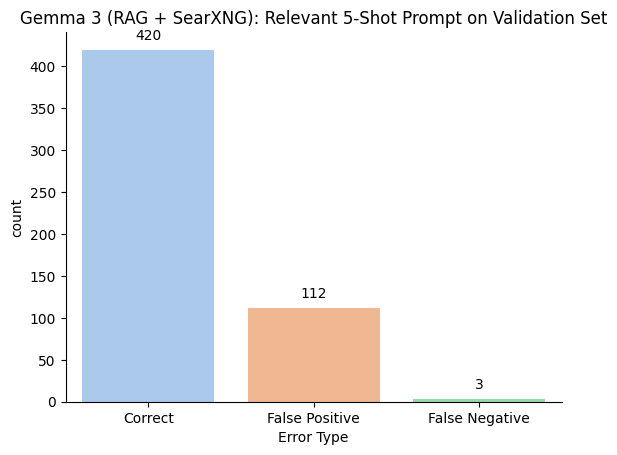

In [144]:
ax = sns.countplot(data=val_df_searxng, x='error_type_predicted_label_5_shot_gemma3', hue='error_type_predicted_label_5_shot_gemma3', palette='pastel')
plt.title('Gemma 3 (RAG + SearXNG): Relevant 5-Shot Prompt on Validation Set')
plt.xlabel('Error Type')
sns.despine()

# add the values on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

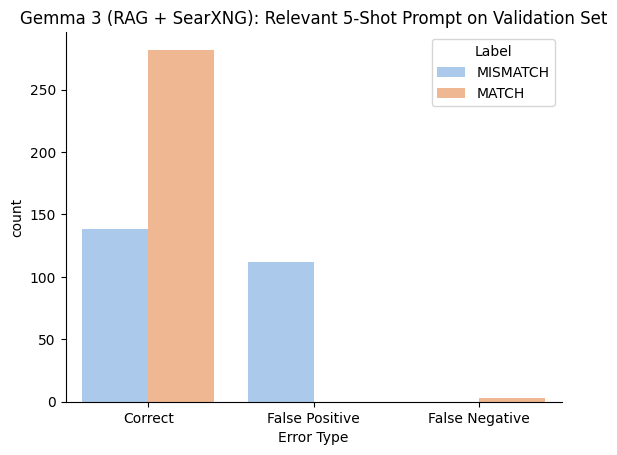

In [145]:
ax = sns.countplot(data=val_df_searxng, x='error_type_predicted_label_5_shot_gemma3', hue='Label', palette='pastel')
plt.title('Gemma 3 (RAG + SearXNG): Relevant 5-Shot Prompt on Validation Set')
plt.xlabel('Error Type')
sns.despine()

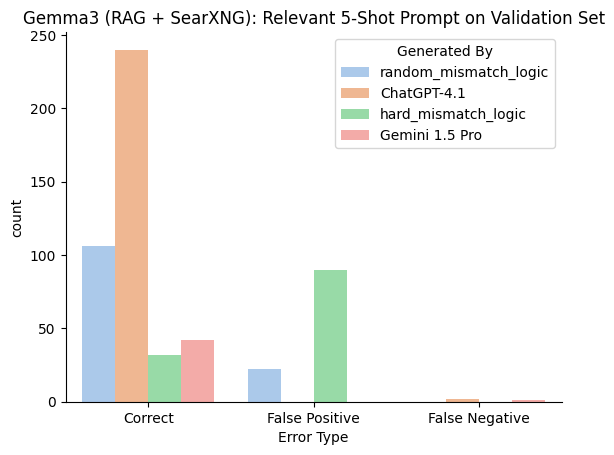

In [147]:
ax = sns.countplot(data=val_df_searxng, x='error_type_predicted_label_5_shot_gemma3', hue='Generated By', palette='pastel')
plt.title('Gemma3 (RAG + SearXNG): Relevant 5-Shot Prompt on Validation Set')
plt.xlabel('Error Type')
sns.despine()

From the above graph, we can see that most of the False Positives come from data generated by the 'hard_mismatch_logic'. 

In [102]:
val_df_searxng[val_df_searxng['error_type_predicted_label_5_shot_gemma3'] == 'False Positive']['Generated By'].value_counts()[:15]

Generated By
hard_mismatch_logic      90
random_mismatch_logic    22
Name: count, dtype: int64

In [94]:
# finding out which of the data is getting misclassified
val_df_searxng[val_df_searxng['error_type_predicted_label_5_shot_gemma3'] == 'False Positive'].head(10)

,Messy Descriptor,Merchant Name,Label,Generated By,Descriptor_Merchant_Combined,predicted_label_5_shot_gemma3,error_type_predicted_label_5_shot_gemma3
2,Ube*POOL-SAN DIEGO,Uber Pool San Diego,MISMATCH,hard_mismatch_logic,Descriptor: Ube*POOL-SAN DIEGO | Merchant: Ube...,MATCH,False Positive
4,REGAL-CN-232-TX,Regal Cinemas Texas,MISMATCH,hard_mismatch_logic,Descriptor: REGAL-CN-232-TX | Merchant: Regal ...,MATCH,False Positive
6,LYFT-BOSTON TRIP 101,Lyft Ride Boston,MISMATCH,hard_mismatch_logic,Descriptor: LYFT-BOSTON TRIP 101 | Merchant: L...,MATCH,False Positive
14,TACO-BELL STR NYK,Taco Bell Store New York,MISMATCH,hard_mismatch_logic,Descriptor: TACO-BELL STR NYK | Merchant: Taco...,MATCH,False Positive
20,TGT-Canada Online Shop,Domino's Pizza San Francisco,MISMATCH,random_mismatch_logic,Descriptor: TGT-Canada Online Shop | Merchant:...,MATCH,False Positive
24,US*NYC Dosuts 002 Dunkn,Dunkin' Donuts US Store,MISMATCH,hard_mismatch_logic,Descriptor: US*NYC Dosuts 002 Dunkn | Merchant...,MATCH,False Positive
28,PEET CFFE NEWYORK_USA,Peet's Coffee New York,MISMATCH,hard_mismatch_logic,Descriptor: PEET CFFE NEWYORK_USA | Merchant: ...,MATCH,False Positive
35,COFF PEETS FLjRIDA,Peet's Coffee Florida Store,MISMATCH,hard_mismatch_logic,Descriptor: COFF PEETS FLjRIDA | Merchant: Pee...,MATCH,False Positive
36,HSB*C CAN# BRNCH #456*,HSBC Canada Branch,MISMATCH,hard_mismatch_logic,Descriptor: HSB*C CAN# BRNCH #456* | Merchant:...,MATCH,False Positive
38,PANERA-BREAD*ST890 BOS,Panera Bread Boston Store 890,MISMATCH,hard_mismatch_logic,Descriptor: PANERA-BREAD*ST890 BOS | Merchant:...,MATCH,False Positive


In [122]:
val_df_searxng.query("error_type_predicted_label_5_shot_gemma3 == 'False Positive' and `Generated By` == 'hard_mismatch_logic'")[['Messy Descriptor', 'Merchant Name', 'Label', 'predicted_label_5_shot_gemma3']].sample(10)

,Messy Descriptor,Merchant Name,Label,predicted_label_5_shot_gemma3
214,#234 ARBYS REST USA,Arby's USA Restaurant,MISMATCH,MATCH
80,STAION VAN*CA 45-67 BP,Amazon Canada Video,MISMATCH,MATCH
342,#456-DALLAS 7 Eleven,7-Eleven Dallas Location 456,MISMATCH,MATCH
153,GFtS*USA EBAY,eBay Gifts USA,MISMATCH,MATCH
94,Exxn Stn HSTN*TX 17,Exxon Station Houston,MISMATCH,MATCH
116,SPOT,Spotify Premium Service,MISMATCH,MATCH
370,LYFTRDE CLGARY CA,Lyft Ride Calgary,MISMATCH,MATCH
14,TACO-BELL STR NYK,Taco Bell Store New York,MISMATCH,MATCH
263,CINMRK *tL THEATERS-213,Cinemark Theatres Florida,MISMATCH,MATCH
149,LMRK THETRE* CA,Amazon Books USA,MISMATCH,MATCH


From the above, we can see that the hard_mismatch_logic is very flawed. 

In [123]:
val_df_searxng.query("error_type_predicted_label_5_shot_gemma3 == 'False Positive' and `Generated By` == 'random_mismatch_logic'")[['Messy Descriptor', 'Merchant Name', 'Label', 'predicted_label_5_shot_gemma3']].sample(10)

,Messy Descriptor,Merchant Name,Label,predicted_label_5_shot_gemma3
378,Spotify SVC - 001 US,Burger King Vancouver,MISMATCH,MATCH
183,PRIME MEMBER AMZ 00991,Netflix Canada Services,MISMATCH,MATCH
48,CHASE-BNK*AMRICA,Aldi USA Store 456,MISMATCH,MATCH
182,ROYAL BANK-CDN 4432,Red Lobster Orlando,MISMATCH,MATCH
141,AMAZN*STREAM US#909,Amazon Books USA,MISMATCH,MATCH
82,SPOTFY DUO PLAN*US,Chase Banking Global,MISMATCH,MATCH
164,STRP-ONLINE PAYMENT,Papa John's Store Texas,MISMATCH,MATCH
456,ARBY'S RSTNT USA*98,BMO Bank Canada,MISMATCH,MATCH
480,SAFEWAY-GROCERY VANCOUVER,Safeway International Grocery,MISMATCH,MATCH
371,ROYALBK INTL * #212,Starbucks Coffee Canada,MISMATCH,MATCH


In [101]:
val_df_searxng[val_df_searxng['error_type_predicted_label_5_shot_gemma3'] == 'False Positive']['Merchant Name'].value_counts()[:15]

Merchant Name
BP Fuel Station Chicago          3
Spotify Premium Service          2
Landmark Theatres Global         2
Stripe Business Solutions        2
PayPal Online Services           2
eBay Home Goods US               2
Tim Hortons Florida Store        2
Home Depot Miami Store 210       2
Texaco Pump Station NYC          2
HSBC Canada Branch               2
Peet's Coffee Florida Store      2
Red Lobster Toronto              2
Panera Bread Store Washington    2
Amazon Books USA                 2
Panera Bread Store Calgary       1
Name: count, dtype: int64

In [130]:
# Evaluating performance of RAG + SearXNG on Relevant 5-shot prompt on test set
predictions, true_labels = classify_batch_with_rag_and_searxng(test_df, index_test, example_lookup_test, embedder, rare_merchants_set, top_k=5, model_name="gemma3")

Classifying rows with RAG + SearXNG: 100%|██████████| 535/535 [05:15<00:00,  1.70it/s]


In [131]:
# classification report
print("Gemma3: RAG + SearXNG Evaluation Based on Relevant 5-Shot Prompt on Test Set:")
print(classification_report(true_labels, predictions))

Gemma3: RAG + SearXNG Evaluation Based on Relevant 5-Shot Prompt on Test Set:
              precision    recall  f1-score   support

       MATCH       0.73      1.00      0.84       285
    MISMATCH       0.99      0.58      0.74       250

    accuracy                           0.80       535
   macro avg       0.86      0.79      0.79       535
weighted avg       0.85      0.80      0.79       535



In [132]:
test_df_searxng = test_df.copy(deep=True)

In [139]:
test_df_searxng['predicted_label_5_shot_gemma3'] = predictions

In [140]:
test_df_searxng['error_type_predicted_label_5_shot_gemma3'] = test_df_searxng.apply(error_type, predicted_label_col='predicted_label_5_shot_gemma3', axis=1)

In [141]:
test_df_searxng['error_type_predicted_label_5_shot_gemma3'].value_counts()

error_type_predicted_label_5_shot_gemma3
Correct           430
False Positive    104
False Negative      1
Name: count, dtype: int64

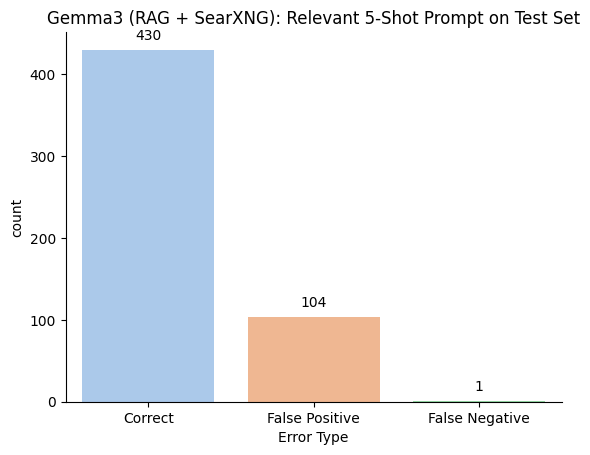

In [143]:
ax = sns.countplot(data=test_df_searxng, x='error_type_predicted_label_5_shot_gemma3', hue='error_type_predicted_label_5_shot_gemma3', palette='pastel')
plt.title('Gemma3 (RAG + SearXNG): Relevant 5-Shot Prompt on Test Set')
plt.xlabel('Error Type')
sns.despine()

# add the values on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

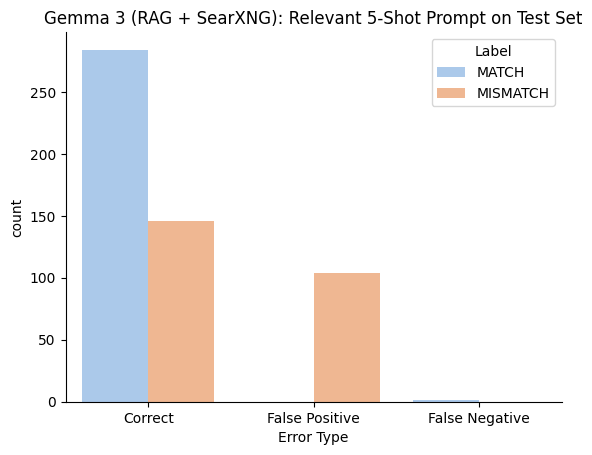

In [146]:
ax = sns.countplot(data=test_df_searxng, x='error_type_predicted_label_5_shot_gemma3', hue='Label', palette='pastel')
plt.title('Gemma 3 (RAG + SearXNG): Relevant 5-Shot Prompt on Test Set')
plt.xlabel('Error Type')
sns.despine()

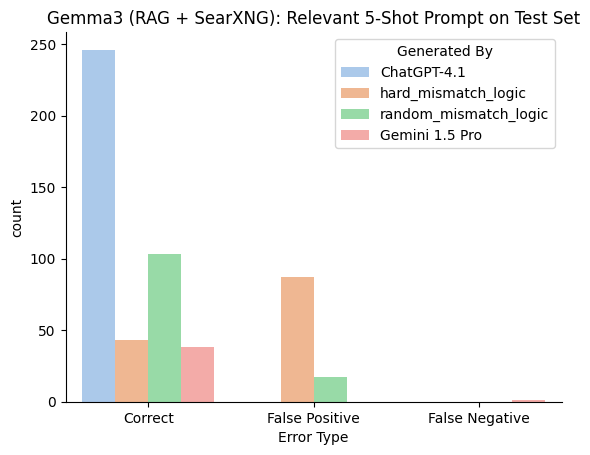

In [148]:
ax = sns.countplot(data=test_df_searxng, x='error_type_predicted_label_5_shot_gemma3', hue='Generated By', palette='pastel')
plt.title('Gemma3 (RAG + SearXNG): Relevant 5-Shot Prompt on Test Set')
plt.xlabel('Error Type')
sns.despine()

##### Llama 3.2

In [149]:
predictions, true_labels = classify_batch_with_rag_and_searxng(train_df, index, example_lookup, embedder, rare_merchants_set, top_k=5, model_name="llama3.2")

Classifying rows with RAG + SearXNG: 100%|██████████| 4280/4280 [32:23<00:00,  2.20it/s] 


In [151]:
cleaned_predictions = [clean_prediction(pred) for pred in predictions]

In [152]:
# classification report
print("Llama 3.2 RAG + SearXNG Evaluation Based on Relevant 5-Shot Prompt on Train Set:")
print(classification_report(true_labels, cleaned_predictions))

Llama 3.2 RAG + SearXNG Evaluation Based on Relevant 5-Shot Prompt on Train Set:
              precision    recall  f1-score   support

       MATCH       0.65      0.77      0.70      2280
    MISMATCH       0.67      0.52      0.58      2000

    accuracy                           0.65      4280
   macro avg       0.66      0.64      0.64      4280
weighted avg       0.66      0.65      0.65      4280



In [153]:
predictions, true_labels = classify_batch_with_rag_and_searxng(val_df, index_val, example_lookup_val, embedder, rare_merchants_set, top_k=5, model_name="llama3.2")

Classifying rows with RAG + SearXNG: 100%|██████████| 535/535 [04:24<00:00,  2.03it/s]


In [154]:
cleaned_predictions = [clean_prediction(pred) for pred in predictions]

In [155]:
# classification report
print("Llama 3.2 RAG + SearXNG Evaluation Based on Relevant 5-Shot Prompt on Validation Set:")
print(classification_report(true_labels, cleaned_predictions))

Llama 3.2 RAG + SearXNG Evaluation Based on Relevant 5-Shot Prompt on Validation Set:
              precision    recall  f1-score   support

       MATCH       0.66      0.83      0.74       285
    MISMATCH       0.73      0.52      0.61       250

    accuracy                           0.69       535
   macro avg       0.70      0.68      0.67       535
weighted avg       0.69      0.69      0.68       535



In [156]:
val_df_searxng['predicted_label_5_shot_llama3'] = cleaned_predictions

In [157]:
val_df_searxng['error_type_predicted_label_5_shot_llama3'] = val_df_searxng.apply(error_type, predicted_label_col='predicted_label_5_shot_llama3', axis=1)

In [158]:
val_df_searxng['error_type_predicted_label_5_shot_llama3'].value_counts()

error_type_predicted_label_5_shot_llama3
Correct           367
False Positive    120
False Negative     48
Name: count, dtype: int64

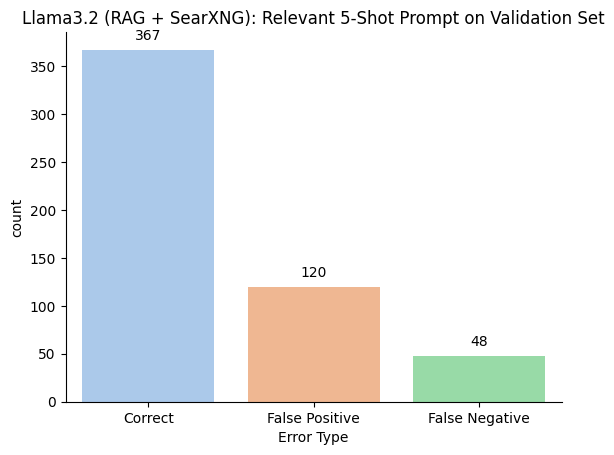

In [159]:
ax = sns.countplot(data=val_df_searxng, x='error_type_predicted_label_5_shot_llama3', hue='error_type_predicted_label_5_shot_llama3', palette='pastel')
plt.title('Llama3.2 (RAG + SearXNG): Relevant 5-Shot Prompt on Validation Set')
plt.xlabel('Error Type')
sns.despine()

# add the values on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

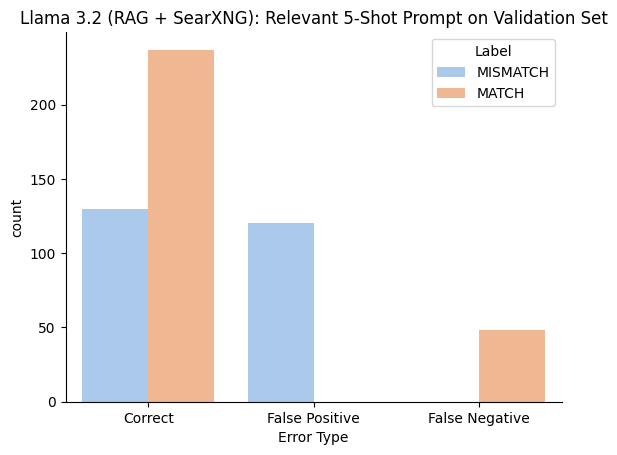

In [160]:
ax = sns.countplot(data=val_df_searxng, x='error_type_predicted_label_5_shot_llama3', hue='Label', palette='pastel')
plt.title('Llama 3.2 (RAG + SearXNG): Relevant 5-Shot Prompt on Validation Set')
plt.xlabel('Error Type')
sns.despine()

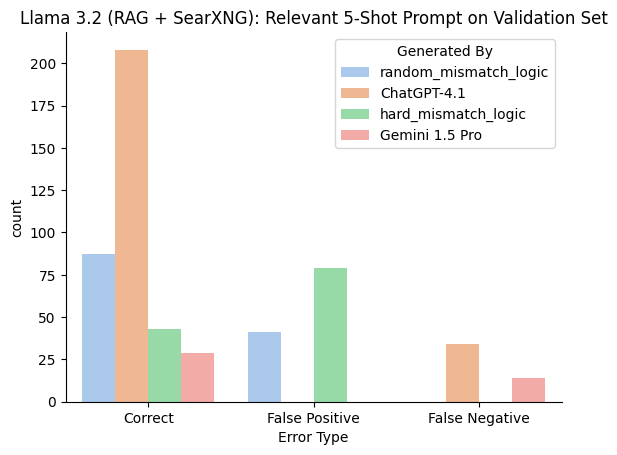

In [161]:
ax = sns.countplot(data=val_df_searxng, x='error_type_predicted_label_5_shot_llama3', hue='Generated By', palette='pastel')
plt.title('Llama 3.2 (RAG + SearXNG): Relevant 5-Shot Prompt on Validation Set')
plt.xlabel('Error Type')
sns.despine()

#### 10-Shot Prompting

##### Gemma 3

In [162]:
predictions, true_labels = classify_batch_with_rag_and_searxng(train_df, index, example_lookup, embedder, rare_merchants_set, top_k=10, model_name="gemma3")

Classifying rows with RAG + SearXNG: 100%|██████████| 4280/4280 [57:27<00:00,  1.24it/s]  


In [163]:
# classification report
print("Gemma3 RAG + SearXNG Evaluation Based on Relevant 10-Shot Prompt on Train Set:")
print(classification_report(true_labels, predictions))

Gemma3 RAG + SearXNG Evaluation Based on Relevant 10-Shot Prompt on Train Set:
              precision    recall  f1-score   support

       MATCH       0.73      0.98      0.83      2280
    MISMATCH       0.96      0.58      0.72      2000

    accuracy                           0.79      4280
   macro avg       0.84      0.78      0.78      4280
weighted avg       0.84      0.79      0.78      4280



In [167]:
predictions, true_labels = classify_batch_with_rag_and_searxng(val_df, index_val, example_lookup_val, embedder, rare_merchants_set, top_k=10, model_name="gemma3")

Classifying rows with RAG + SearXNG: 100%|██████████| 535/535 [07:46<00:00,  1.15it/s]


In [168]:
# classification report
print("Gemma3 RAG + SearXNG Evaluation Based on Relevant 10-Shot Prompt on Validation Set:")
print(classification_report(true_labels, predictions))

Gemma3 RAG + SearXNG Evaluation Based on Relevant 10-Shot Prompt on Validation Set:
              precision    recall  f1-score   support

       MATCH       0.79      0.99      0.88       285
    MISMATCH       0.98      0.70      0.82       250

    accuracy                           0.86       535
   macro avg       0.89      0.85      0.85       535
weighted avg       0.88      0.86      0.85       535



In [170]:
val_df_searxng['predicted_label_10_shot_gemma3'] = predictions
val_df_searxng['error_type_predicted_label_10_shot_gemma3'] = val_df_searxng.apply(error_type, predicted_label_col='predicted_label_10_shot_gemma3', axis=1)
val_df_searxng['error_type_predicted_label_10_shot_gemma3'].value_counts()

error_type_predicted_label_10_shot_gemma3
Correct           458
False Positive     74
False Negative      3
Name: count, dtype: int64

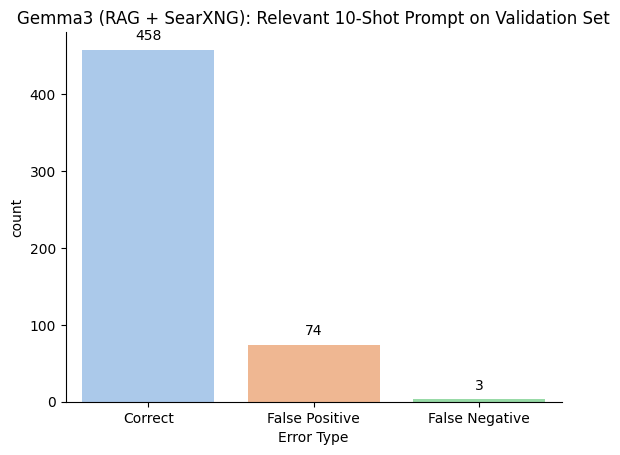

In [171]:
ax = sns.countplot(data=val_df_searxng, x='error_type_predicted_label_10_shot_gemma3', hue='error_type_predicted_label_10_shot_gemma3', palette='pastel')
plt.title('Gemma3 (RAG + SearXNG): Relevant 10-Shot Prompt on Validation Set')
plt.xlabel('Error Type')
sns.despine()

# add the values on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

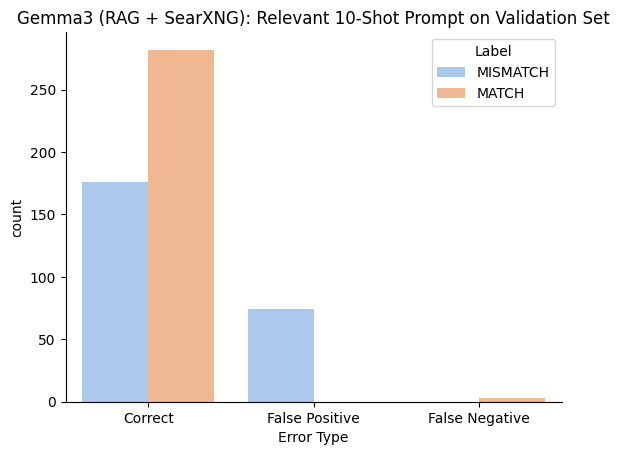

In [172]:
ax = sns.countplot(data=val_df_searxng, x='error_type_predicted_label_10_shot_gemma3', hue='Label', palette='pastel')
plt.title('Gemma3 (RAG + SearXNG): Relevant 10-Shot Prompt on Validation Set')
plt.xlabel('Error Type')
sns.despine()

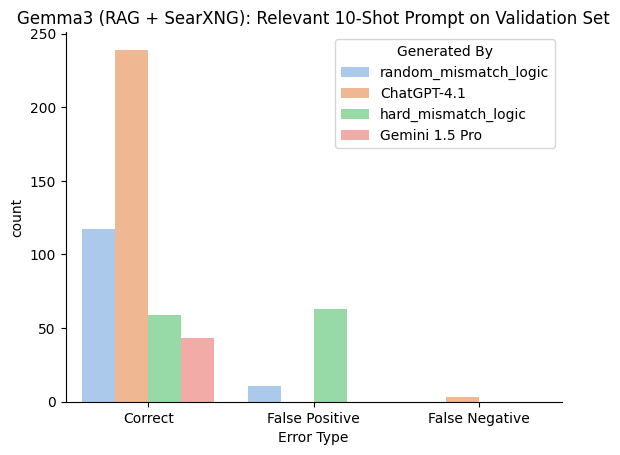

In [173]:
ax = sns.countplot(data=val_df_searxng, x='error_type_predicted_label_10_shot_gemma3', hue='Generated By', palette='pastel')
plt.title('Gemma3 (RAG + SearXNG): Relevant 10-Shot Prompt on Validation Set')
plt.xlabel('Error Type')
sns.despine()

In [174]:
predictions, true_labels = classify_batch_with_rag_and_searxng(test_df, index_test, example_lookup_test, embedder, rare_merchants_set, top_k=10, model_name="gemma3")

Classifying rows with RAG + SearXNG: 100%|██████████| 535/535 [07:36<00:00,  1.17it/s]


In [175]:
# classification report
print("Gemma3 RAG + SearXNG Evaluation Based on Relevant 10-Shot Prompt on Test Set:")
print(classification_report(true_labels, predictions))

Gemma3 RAG + SearXNG Evaluation Based on Relevant 10-Shot Prompt on Test Set:
              precision    recall  f1-score   support

       MATCH       0.79      1.00      0.88       285
    MISMATCH       1.00      0.70      0.82       250

    accuracy                           0.86       535
   macro avg       0.89      0.85      0.85       535
weighted avg       0.89      0.86      0.85       535



In [176]:
test_df_searxng['predicted_label_10_shot_gemma3'] = predictions
test_df_searxng['error_type_predicted_label_10_shot_gemma3'] = test_df_searxng.apply(error_type, predicted_label_col='predicted_label_10_shot_gemma3', axis=1)
test_df_searxng['error_type_predicted_label_10_shot_gemma3'].value_counts()

error_type_predicted_label_10_shot_gemma3
Correct           459
False Positive     76
Name: count, dtype: int64

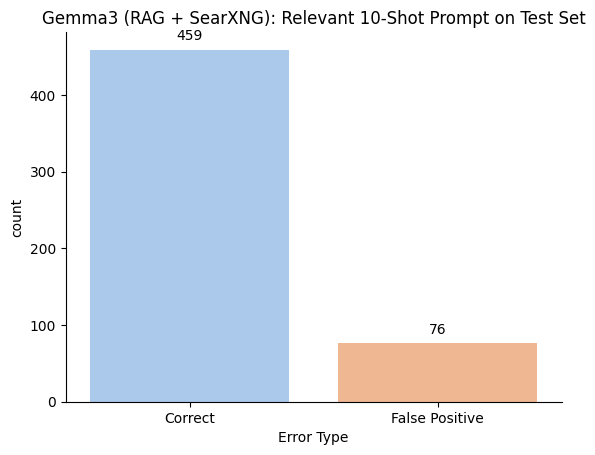

In [177]:
ax = sns.countplot(data=test_df_searxng, x='error_type_predicted_label_10_shot_gemma3', hue='error_type_predicted_label_10_shot_gemma3', palette='pastel')
plt.title('Gemma3 (RAG + SearXNG): Relevant 10-Shot Prompt on Test Set')
plt.xlabel('Error Type')
sns.despine()

# add the values on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

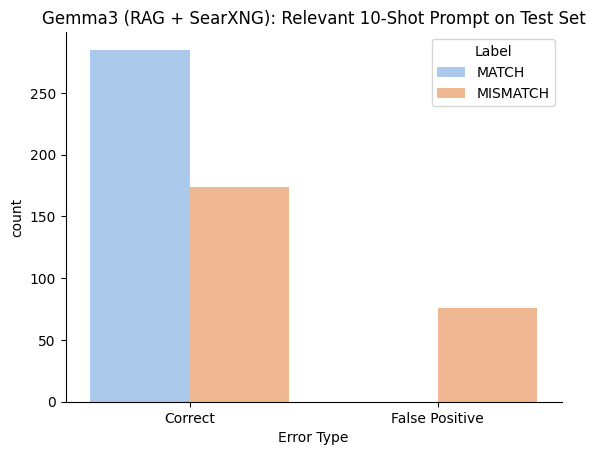

In [178]:
ax = sns.countplot(data=test_df_searxng, x='error_type_predicted_label_10_shot_gemma3', hue='Label', palette='pastel')
plt.title('Gemma3 (RAG + SearXNG): Relevant 10-Shot Prompt on Test Set')
plt.xlabel('Error Type')
sns.despine()

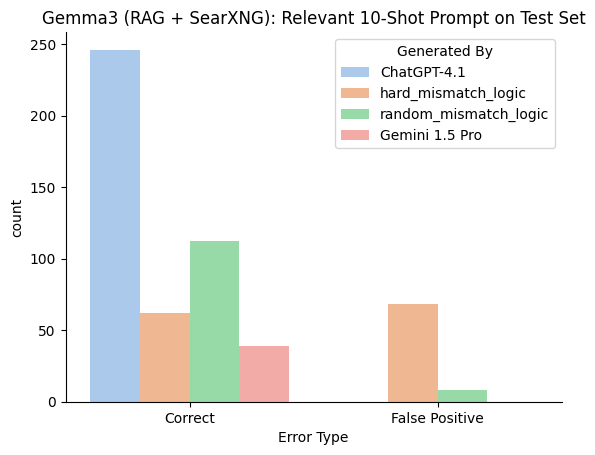

In [179]:
ax = sns.countplot(data=test_df_searxng, x='error_type_predicted_label_10_shot_gemma3', hue='Generated By', palette='pastel')
plt.title('Gemma3 (RAG + SearXNG): Relevant 10-Shot Prompt on Test Set')
plt.xlabel('Error Type')
sns.despine()

##### Llama 3.2

In [164]:
predictions, true_labels = classify_batch_with_rag_and_searxng(train_df, index, example_lookup, embedder, rare_merchants_set, top_k=10, model_name="llama3.2")

Classifying rows with RAG + SearXNG: 100%|██████████| 4280/4280 [48:54<00:00,  1.46it/s]  


In [165]:
cleaned_predictions = [clean_prediction(pred) for pred in predictions]

In [166]:
# classification report
print("Llama3.2 RAG + SearXNG Evaluation Based on Relevant 10-Shot Prompt on Train Set:")
print(classification_report(true_labels, cleaned_predictions))

Llama3.2 RAG + SearXNG Evaluation Based on Relevant 10-Shot Prompt on Train Set:
              precision    recall  f1-score   support

       MATCH       0.68      0.80      0.73      2280
    MISMATCH       0.71      0.56      0.63      2000

    accuracy                           0.69      4280
   macro avg       0.69      0.68      0.68      4280
weighted avg       0.69      0.69      0.68      4280



In [180]:
predictions, true_labels = classify_batch_with_rag_and_searxng(val_df, index_val, example_lookup_val, embedder, rare_merchants_set, top_k=10, model_name="llama3.2")

Classifying rows with RAG + SearXNG: 100%|██████████| 535/535 [06:15<00:00,  1.42it/s]


In [181]:
cleaned_predictions = [clean_prediction(pred) for pred in predictions]
# classification report
print("Llama3.2 RAG + SearXNG Evaluation Based on Relevant 10-Shot Prompt on Validation Set:")
print(classification_report(true_labels, cleaned_predictions))

Llama3.2 RAG + SearXNG Evaluation Based on Relevant 10-Shot Prompt on Validation Set:
              precision    recall  f1-score   support

       MATCH       0.70      0.88      0.78       285
    MISMATCH       0.80      0.56      0.66       250

    accuracy                           0.73       535
   macro avg       0.75      0.72      0.72       535
weighted avg       0.75      0.73      0.72       535



In [182]:
val_df_searxng['predicted_label_10_shot_llama3'] = cleaned_predictions
val_df_searxng['error_type_predicted_label_10_shot_llama3'] = val_df_searxng.apply(error_type, predicted_label_col='predicted_label_10_shot_llama3', axis=1)
val_df_searxng['error_type_predicted_label_10_shot_llama3'].value_counts()

error_type_predicted_label_10_shot_llama3
Correct           391
False Positive    110
False Negative     34
Name: count, dtype: int64

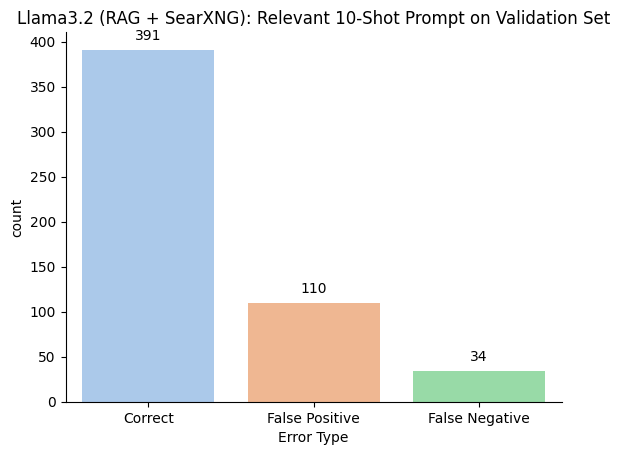

In [183]:
ax = sns.countplot(data=val_df_searxng, x='error_type_predicted_label_10_shot_llama3', hue='error_type_predicted_label_10_shot_llama3', palette='pastel')
plt.title('Llama3.2 (RAG + SearXNG): Relevant 10-Shot Prompt on Validation Set')
plt.xlabel('Error Type')
sns.despine()

# add the values on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

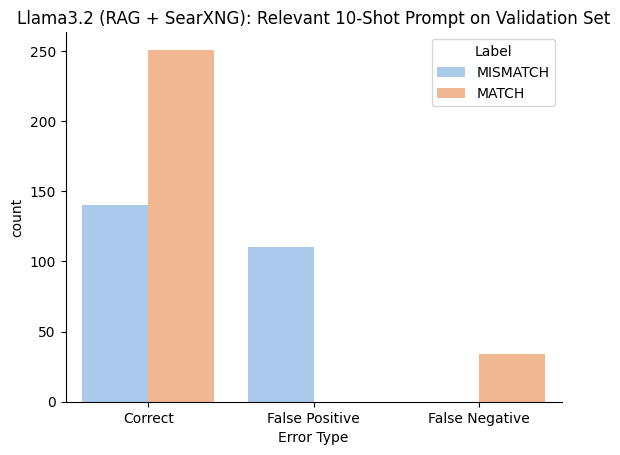

In [184]:
ax = sns.countplot(data=val_df_searxng, x='error_type_predicted_label_10_shot_llama3', hue='Label', palette='pastel')
plt.title('Llama3.2 (RAG + SearXNG): Relevant 10-Shot Prompt on Validation Set')
plt.xlabel('Error Type')
sns.despine()

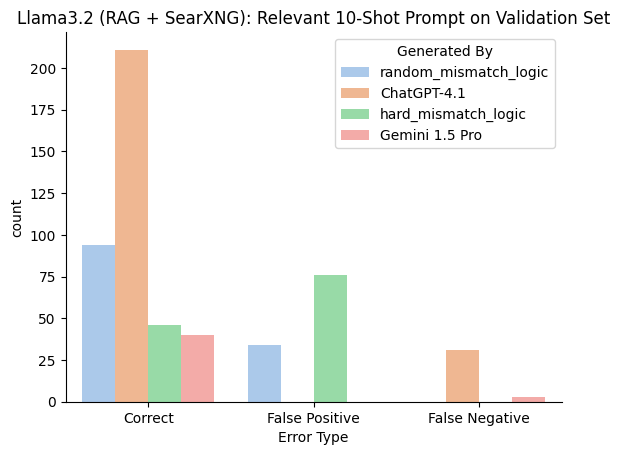

In [185]:
ax = sns.countplot(data=val_df_searxng, x='error_type_predicted_label_10_shot_llama3', hue='Generated By', palette='pastel')
plt.title('Llama3.2 (RAG + SearXNG): Relevant 10-Shot Prompt on Validation Set')
plt.xlabel('Error Type')
sns.despine()

In [186]:
predictions, true_labels = classify_batch_with_rag_and_searxng(test_df, index_test, example_lookup_test, embedder, rare_merchants_set, top_k=10, model_name="llama3.2")

Classifying rows with RAG + SearXNG: 100%|██████████| 535/535 [06:17<00:00,  1.42it/s]


In [187]:
cleaned_predictions = [clean_prediction(pred) for pred in predictions]
# classification report
print("Llama3.2 RAG + SearXNG Evaluation Based on Relevant 10-Shot Prompt on Test Set:")
print(classification_report(true_labels, cleaned_predictions))

Llama3.2 RAG + SearXNG Evaluation Based on Relevant 10-Shot Prompt on Test Set:
              precision    recall  f1-score   support

       MATCH       0.71      0.90      0.80       285
    MISMATCH       0.84      0.59      0.69       250

    accuracy                           0.75       535
   macro avg       0.77      0.74      0.74       535
weighted avg       0.77      0.75      0.75       535



In [188]:
test_df_searxng['predicted_label_10_shot_llama3'] = cleaned_predictions
test_df_searxng['error_type_predicted_label_10_shot_llama3'] = test_df_searxng.apply(error_type, predicted_label_col='predicted_label_10_shot_llama3', axis=1)
test_df_searxng['error_type_predicted_label_10_shot_llama3'].value_counts()

error_type_predicted_label_10_shot_llama3
Correct           403
False Positive    103
False Negative     29
Name: count, dtype: int64

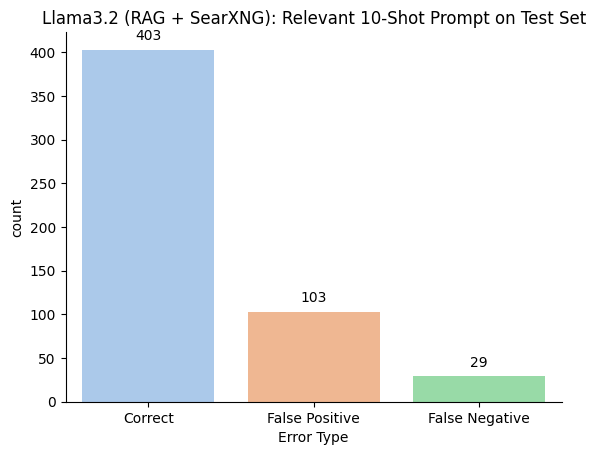

In [189]:
ax = sns.countplot(data=test_df_searxng, x='error_type_predicted_label_10_shot_llama3', hue='error_type_predicted_label_10_shot_llama3', palette='pastel')
plt.title('Llama3.2 (RAG + SearXNG): Relevant 10-Shot Prompt on Test Set')
plt.xlabel('Error Type')
sns.despine()

# add the values on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

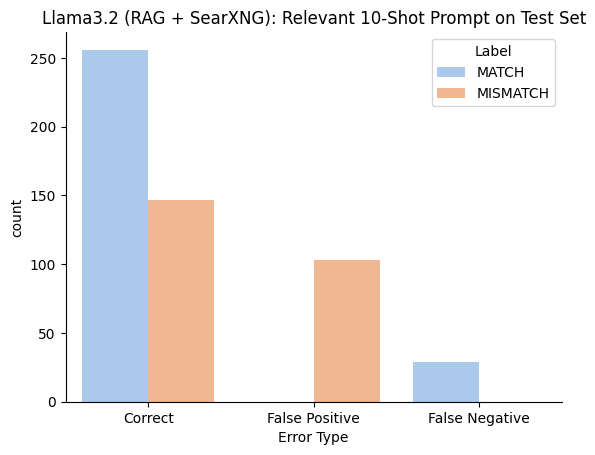

In [190]:
ax = sns.countplot(data=test_df_searxng, x='error_type_predicted_label_10_shot_llama3', hue='Label', palette='pastel')
plt.title('Llama3.2 (RAG + SearXNG): Relevant 10-Shot Prompt on Test Set')
plt.xlabel('Error Type')
sns.despine()

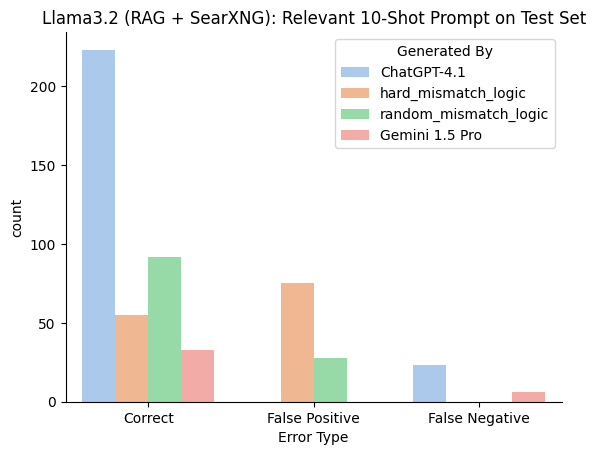

In [191]:
ax = sns.countplot(data=test_df_searxng, x='error_type_predicted_label_10_shot_llama3', hue='Generated By', palette='pastel')
plt.title('Llama3.2 (RAG + SearXNG): Relevant 10-Shot Prompt on Test Set')
plt.xlabel('Error Type')
sns.despine()

# 7. Conclusion

In this report, I have analyzed the performance of a traditional XG Boost Model along with Gemma 3 & LLaMA 3.2 for a text classification task. The Gemma 3 model along with RAG performed the best on this task with a macro F1-score of 0.86 on the test set. The extra step of using SearXNG to get more details of the merchant did not necessarily improve the performance of the Gemma 3 model, however it made a notable improvement for the LLaMA 3.2 model. This project shows how certain LLMs like Gemma 3 can have significant improvement to traditional machine learning models which are trained specifically for one task.